# Начало

In [1]:
import numpy as np

from dto import Point, GeoPoint
from SpeedPredictor import MotionConstraints, PureLateralLimitTurnPolicy, SpeedPredictor
from PumpController import BoundaryAction, PumpConstraints, PumpController
from utils import polyline_lengths, point_on_path, simulate_time_param
from plots import plot_polygon

## Загрузка лог файла

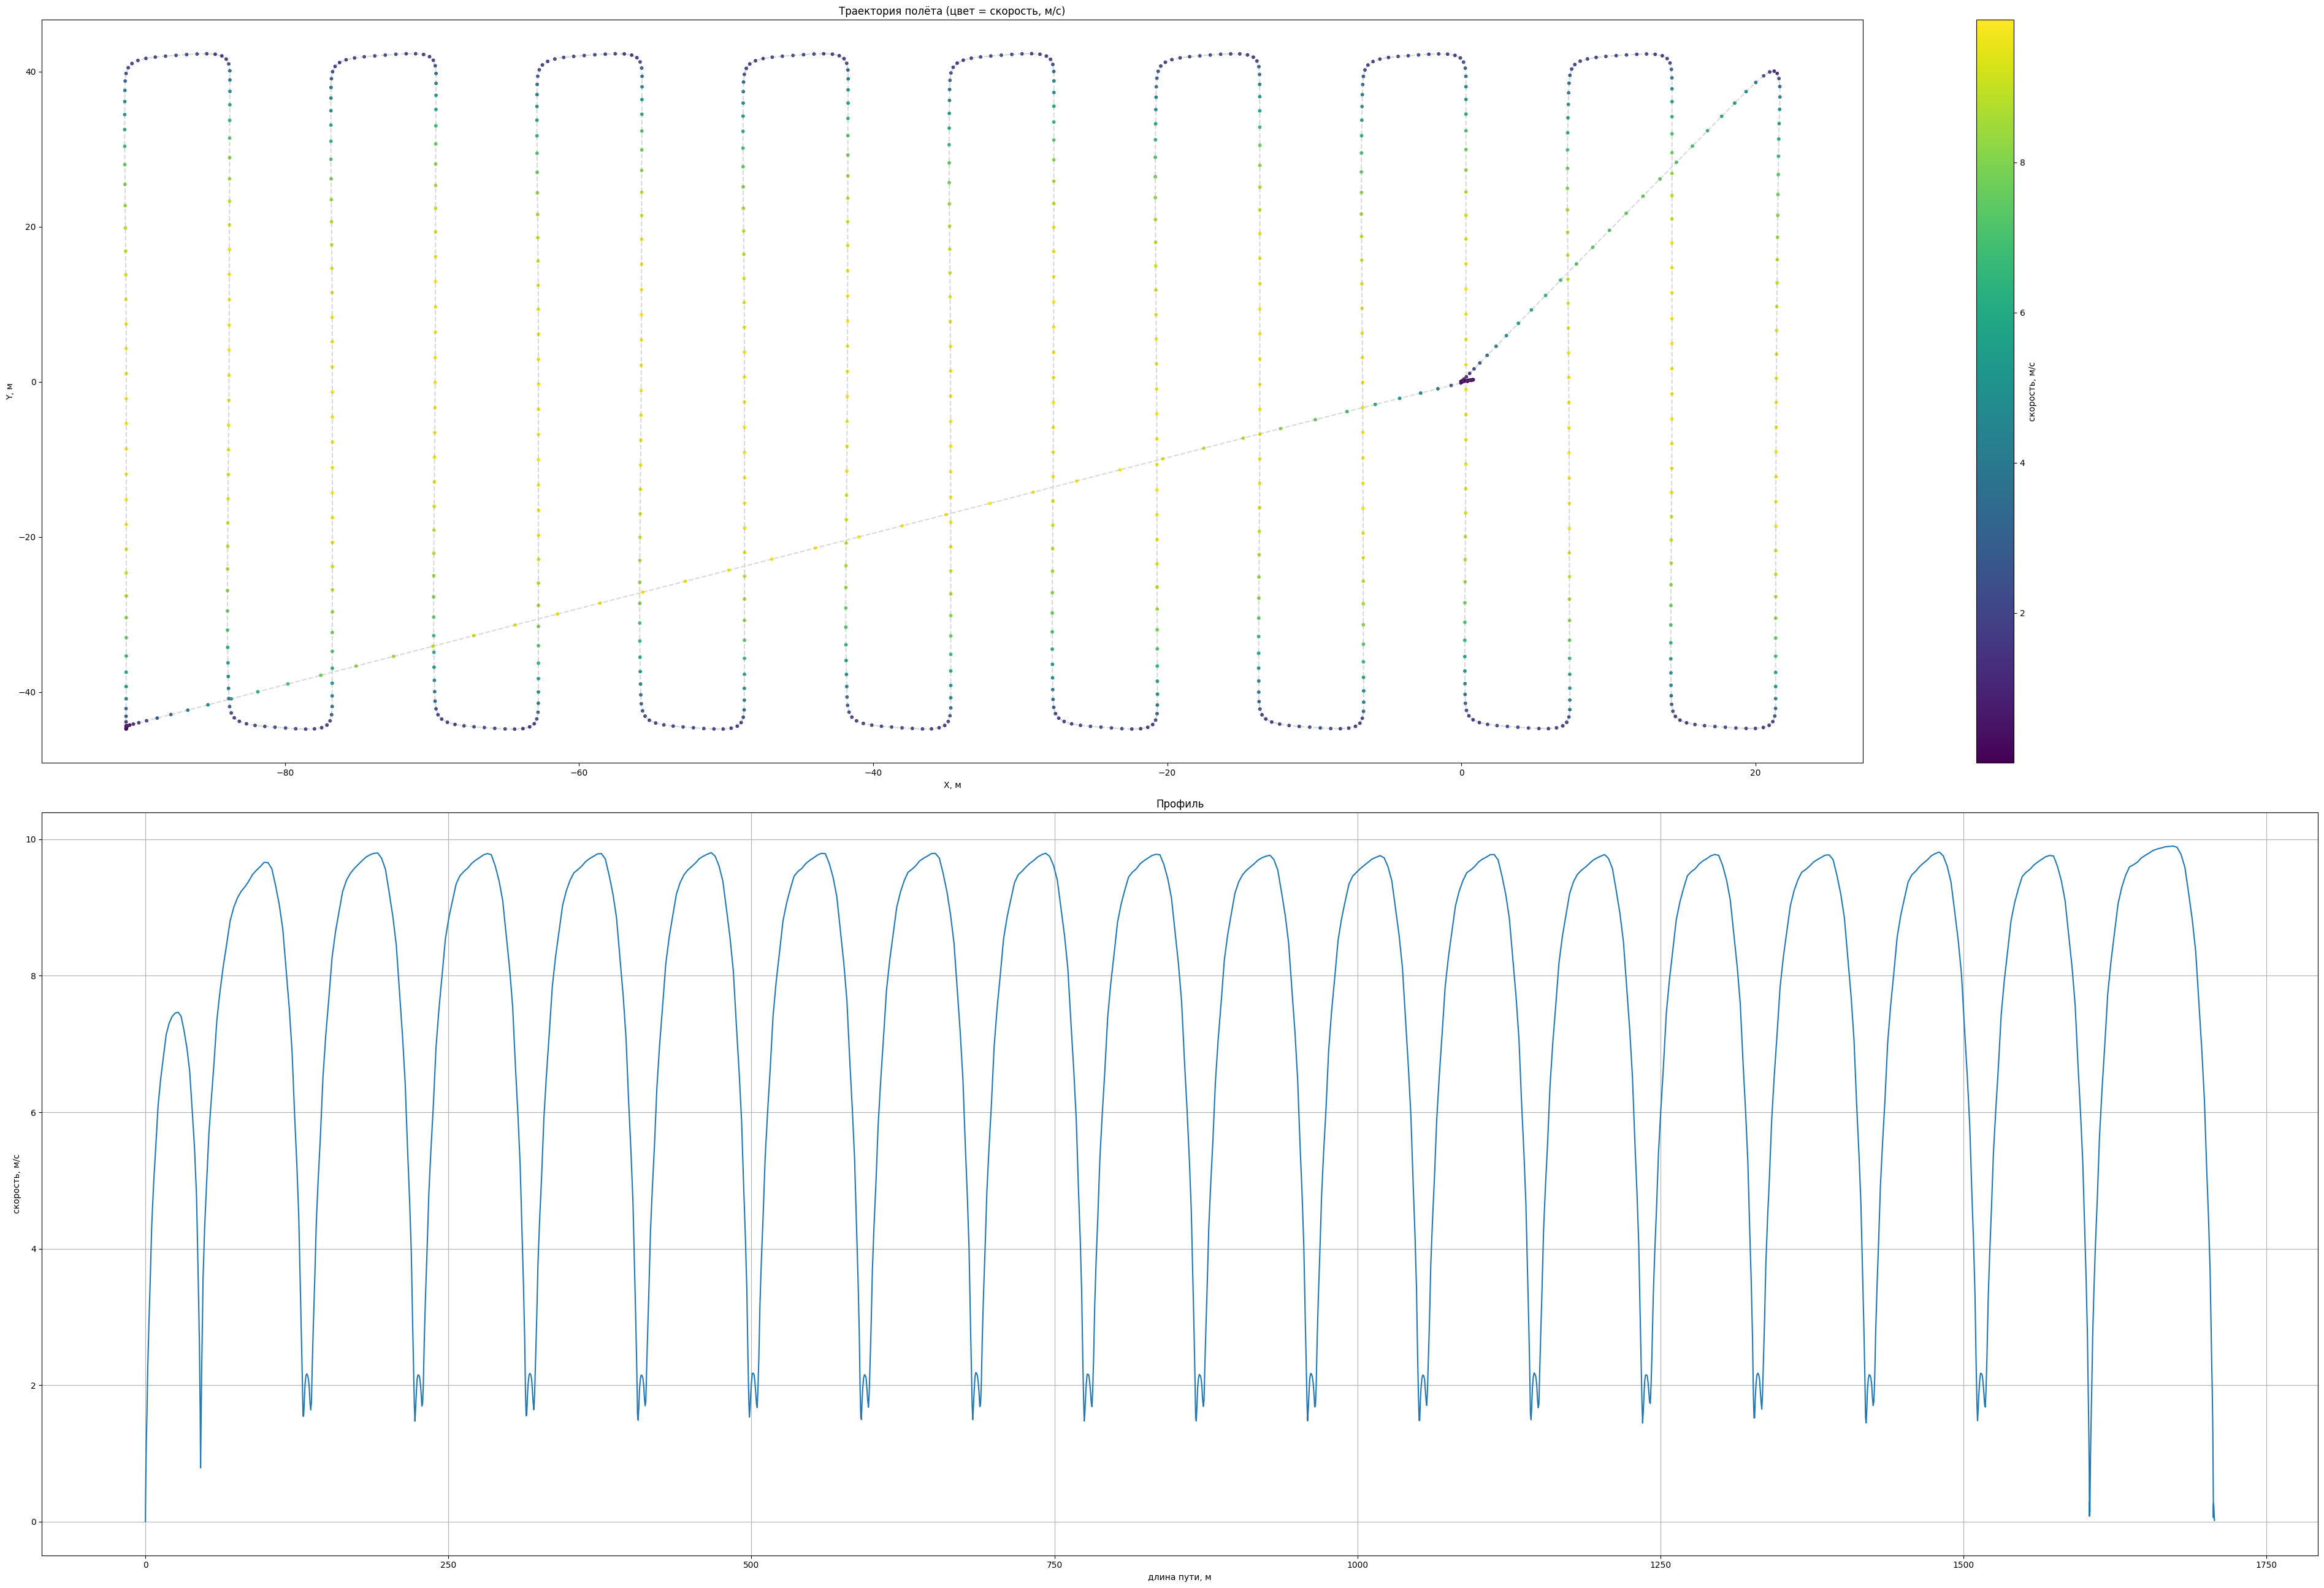

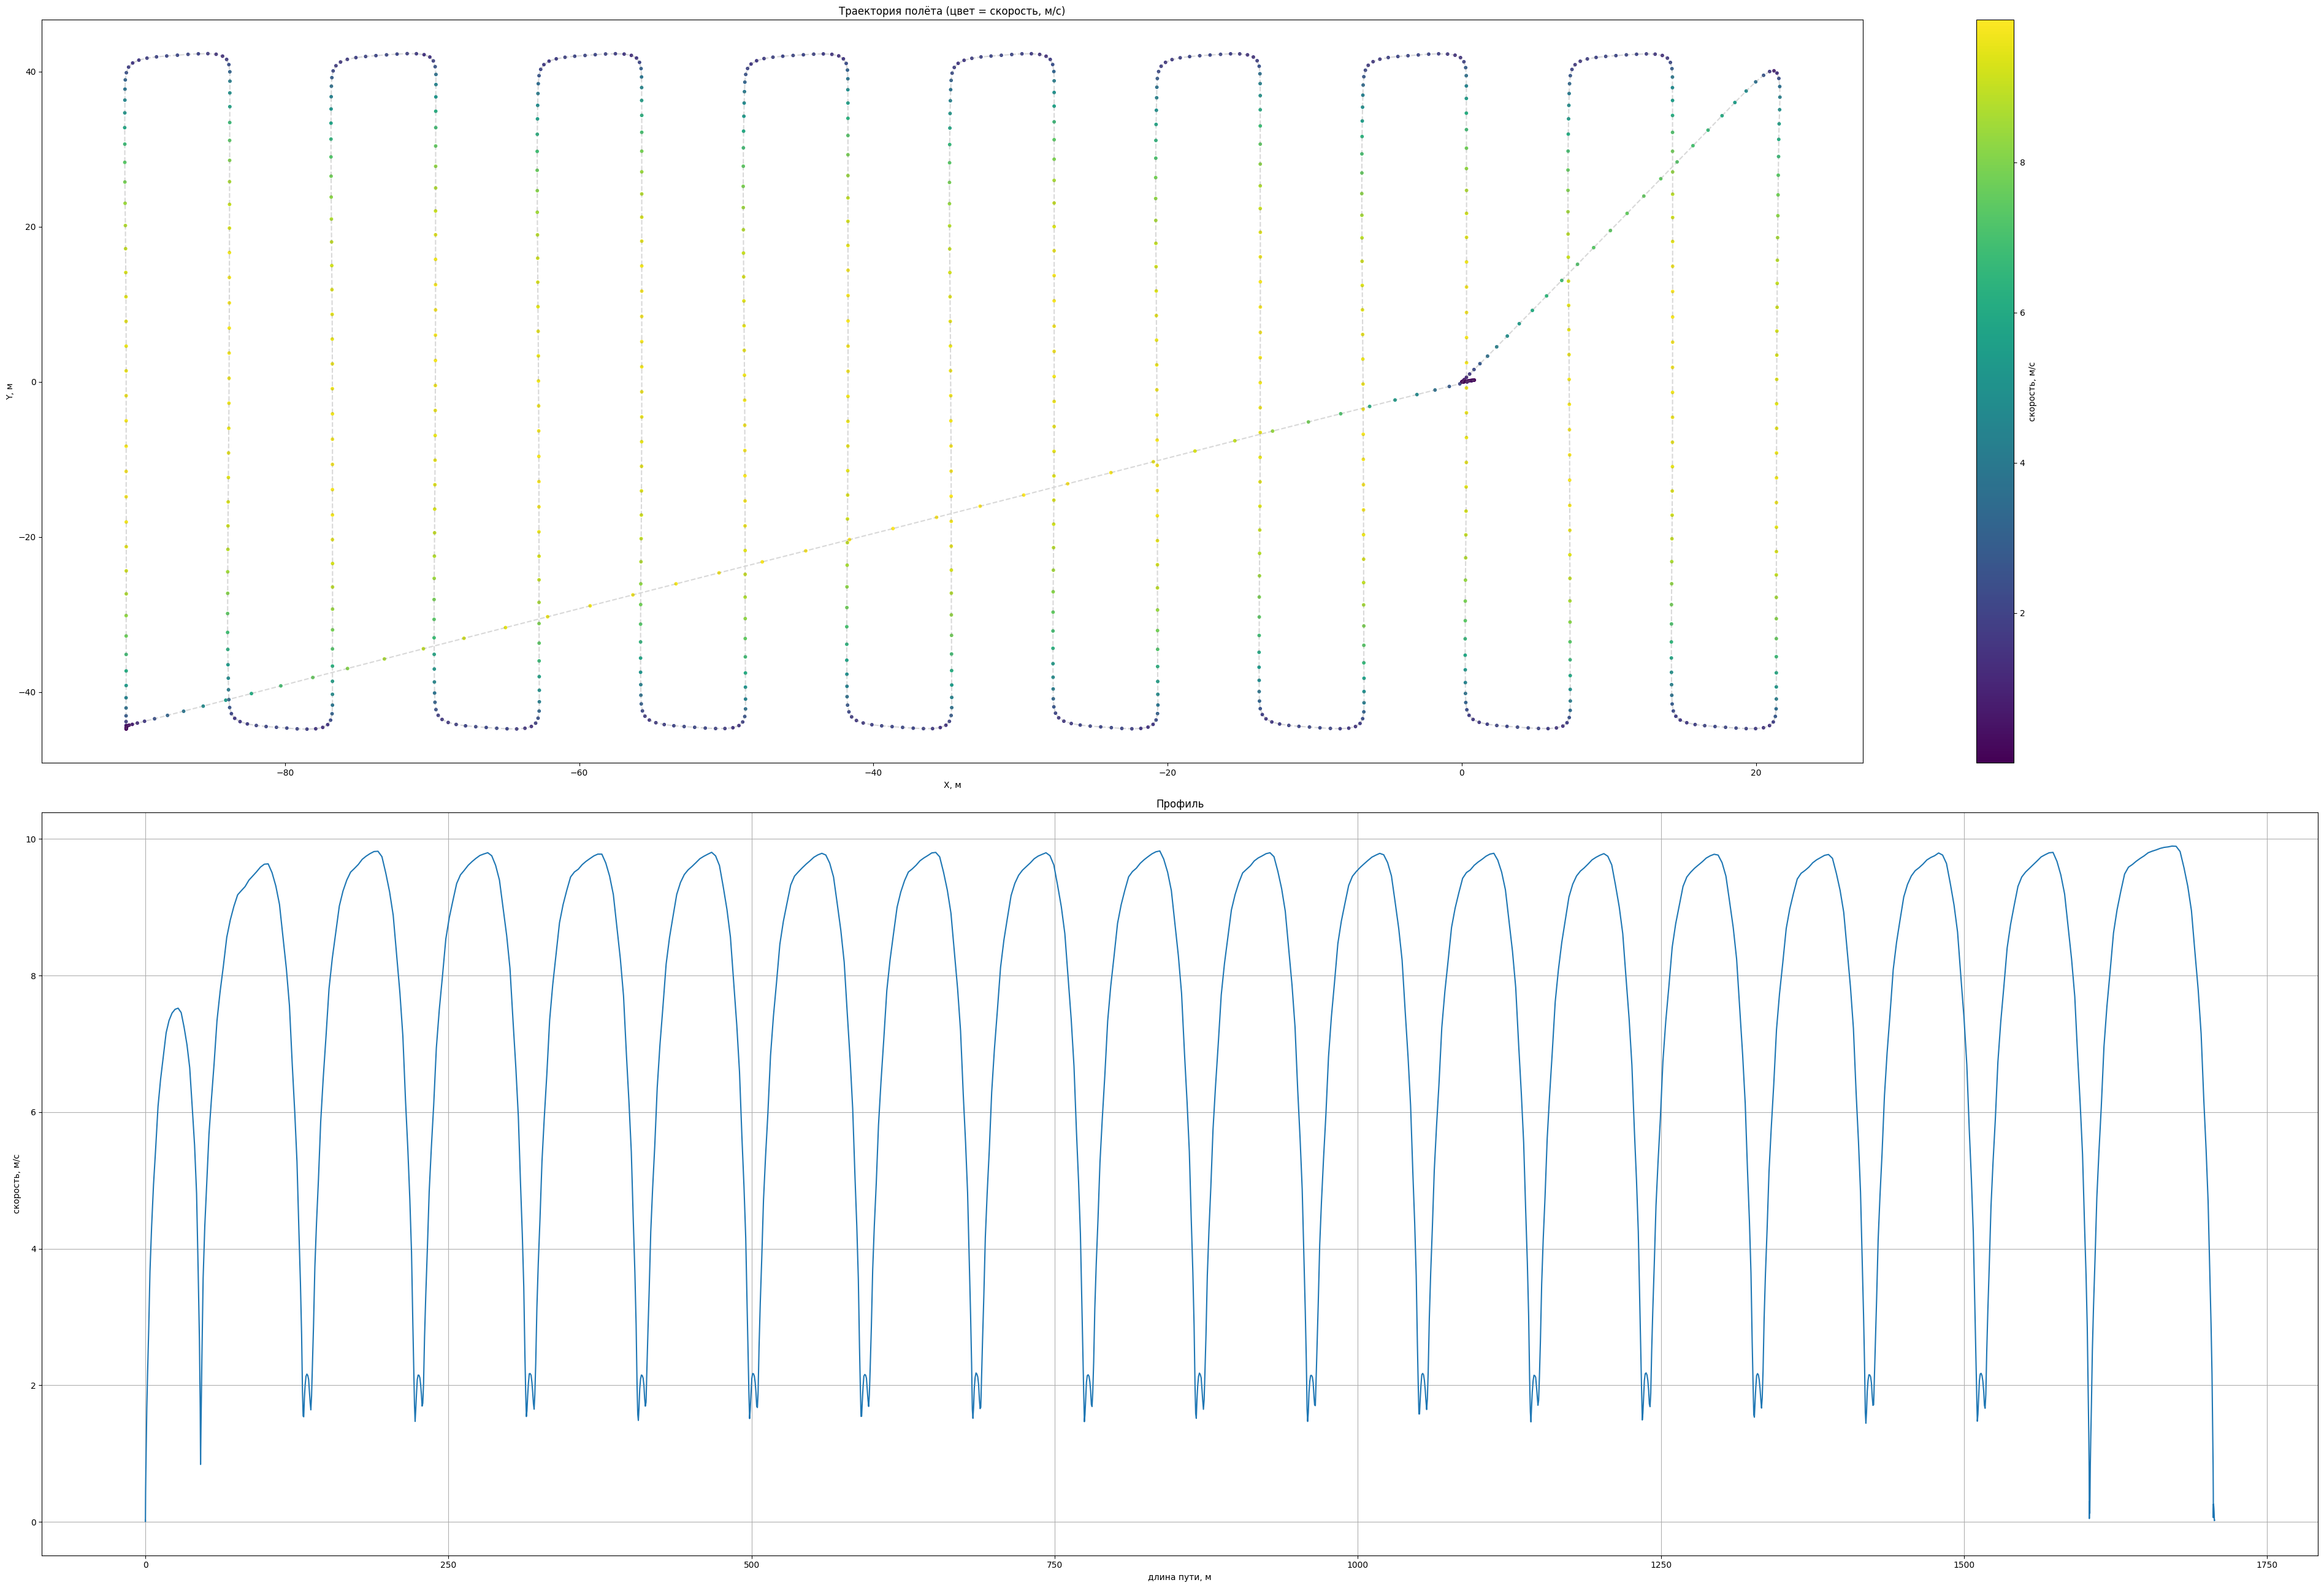

[Warning] Корректная обработка полётов в количестве более 1 ещё не реализована


In [2]:
from parse_log import Plan, Logs
from pathlib import Path

path_to_file = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(path_to_file)

in_logs = Logs(path_to_file)

## Визуализация плана мисии

In [3]:

from GeoTransformer import GeoTransformer

geo_transformer = GeoTransformer()


def to_xy(p: GeoPoint) -> Point:
    return geo_transformer.geo_to_xy(plan.center_geo, p)


def to_geo(p: Point) -> GeoPoint:
    return geo_transformer.xy_to_geo(plan.center_geo, p)


def to_xy_points(gp: list[GeoPoint]) -> list[Point]:
    return [to_xy(p) for p in gp]

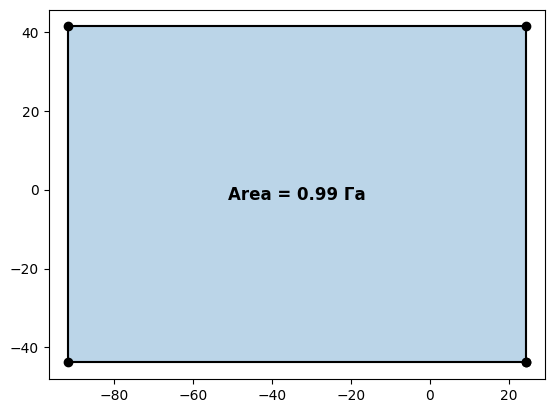

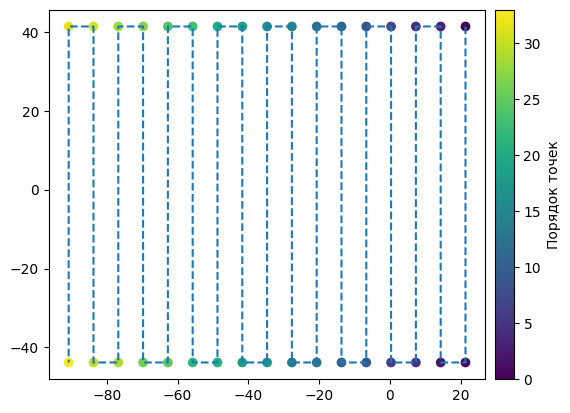

In [4]:
from plots import scatter_with_color

plot_polygon(plan.polygon)
scatter_with_color(plan.waypoints_xy, list(range(len(plan.waypoints_xy))), 'Порядок точек')

# Ограничения

In [35]:
motion = MotionConstraints(
    v_max=10.0,
    a_max=1.0,
    d_max=1.0,
    yaw_rate=10,
    turn_radius=2,
    a_lat_max=2.0,
    angle_eps_deg=1.0,
    start_speed=0.0,
    end_speed=0.0
)

predictor = SpeedPredictor(motion, PureLateralLimitTurnPolicy())

norma = 10  # Норма внесения Литры/Га
pump_min_speed = 1  # л/мин
pump_max_speed = 13  # л/мин
tank_volume = 40  # л

constraints = PumpConstraints(
    q_min=pump_min_speed / 60,  # л/с
    q_max=pump_max_speed / 60,  # л/с
    tank_volume=tank_volume,  # л
    low_mode=BoundaryAction.CLAMP,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)


# Предсказанный на основе плана

## Предсказанный профиль скорости дрона

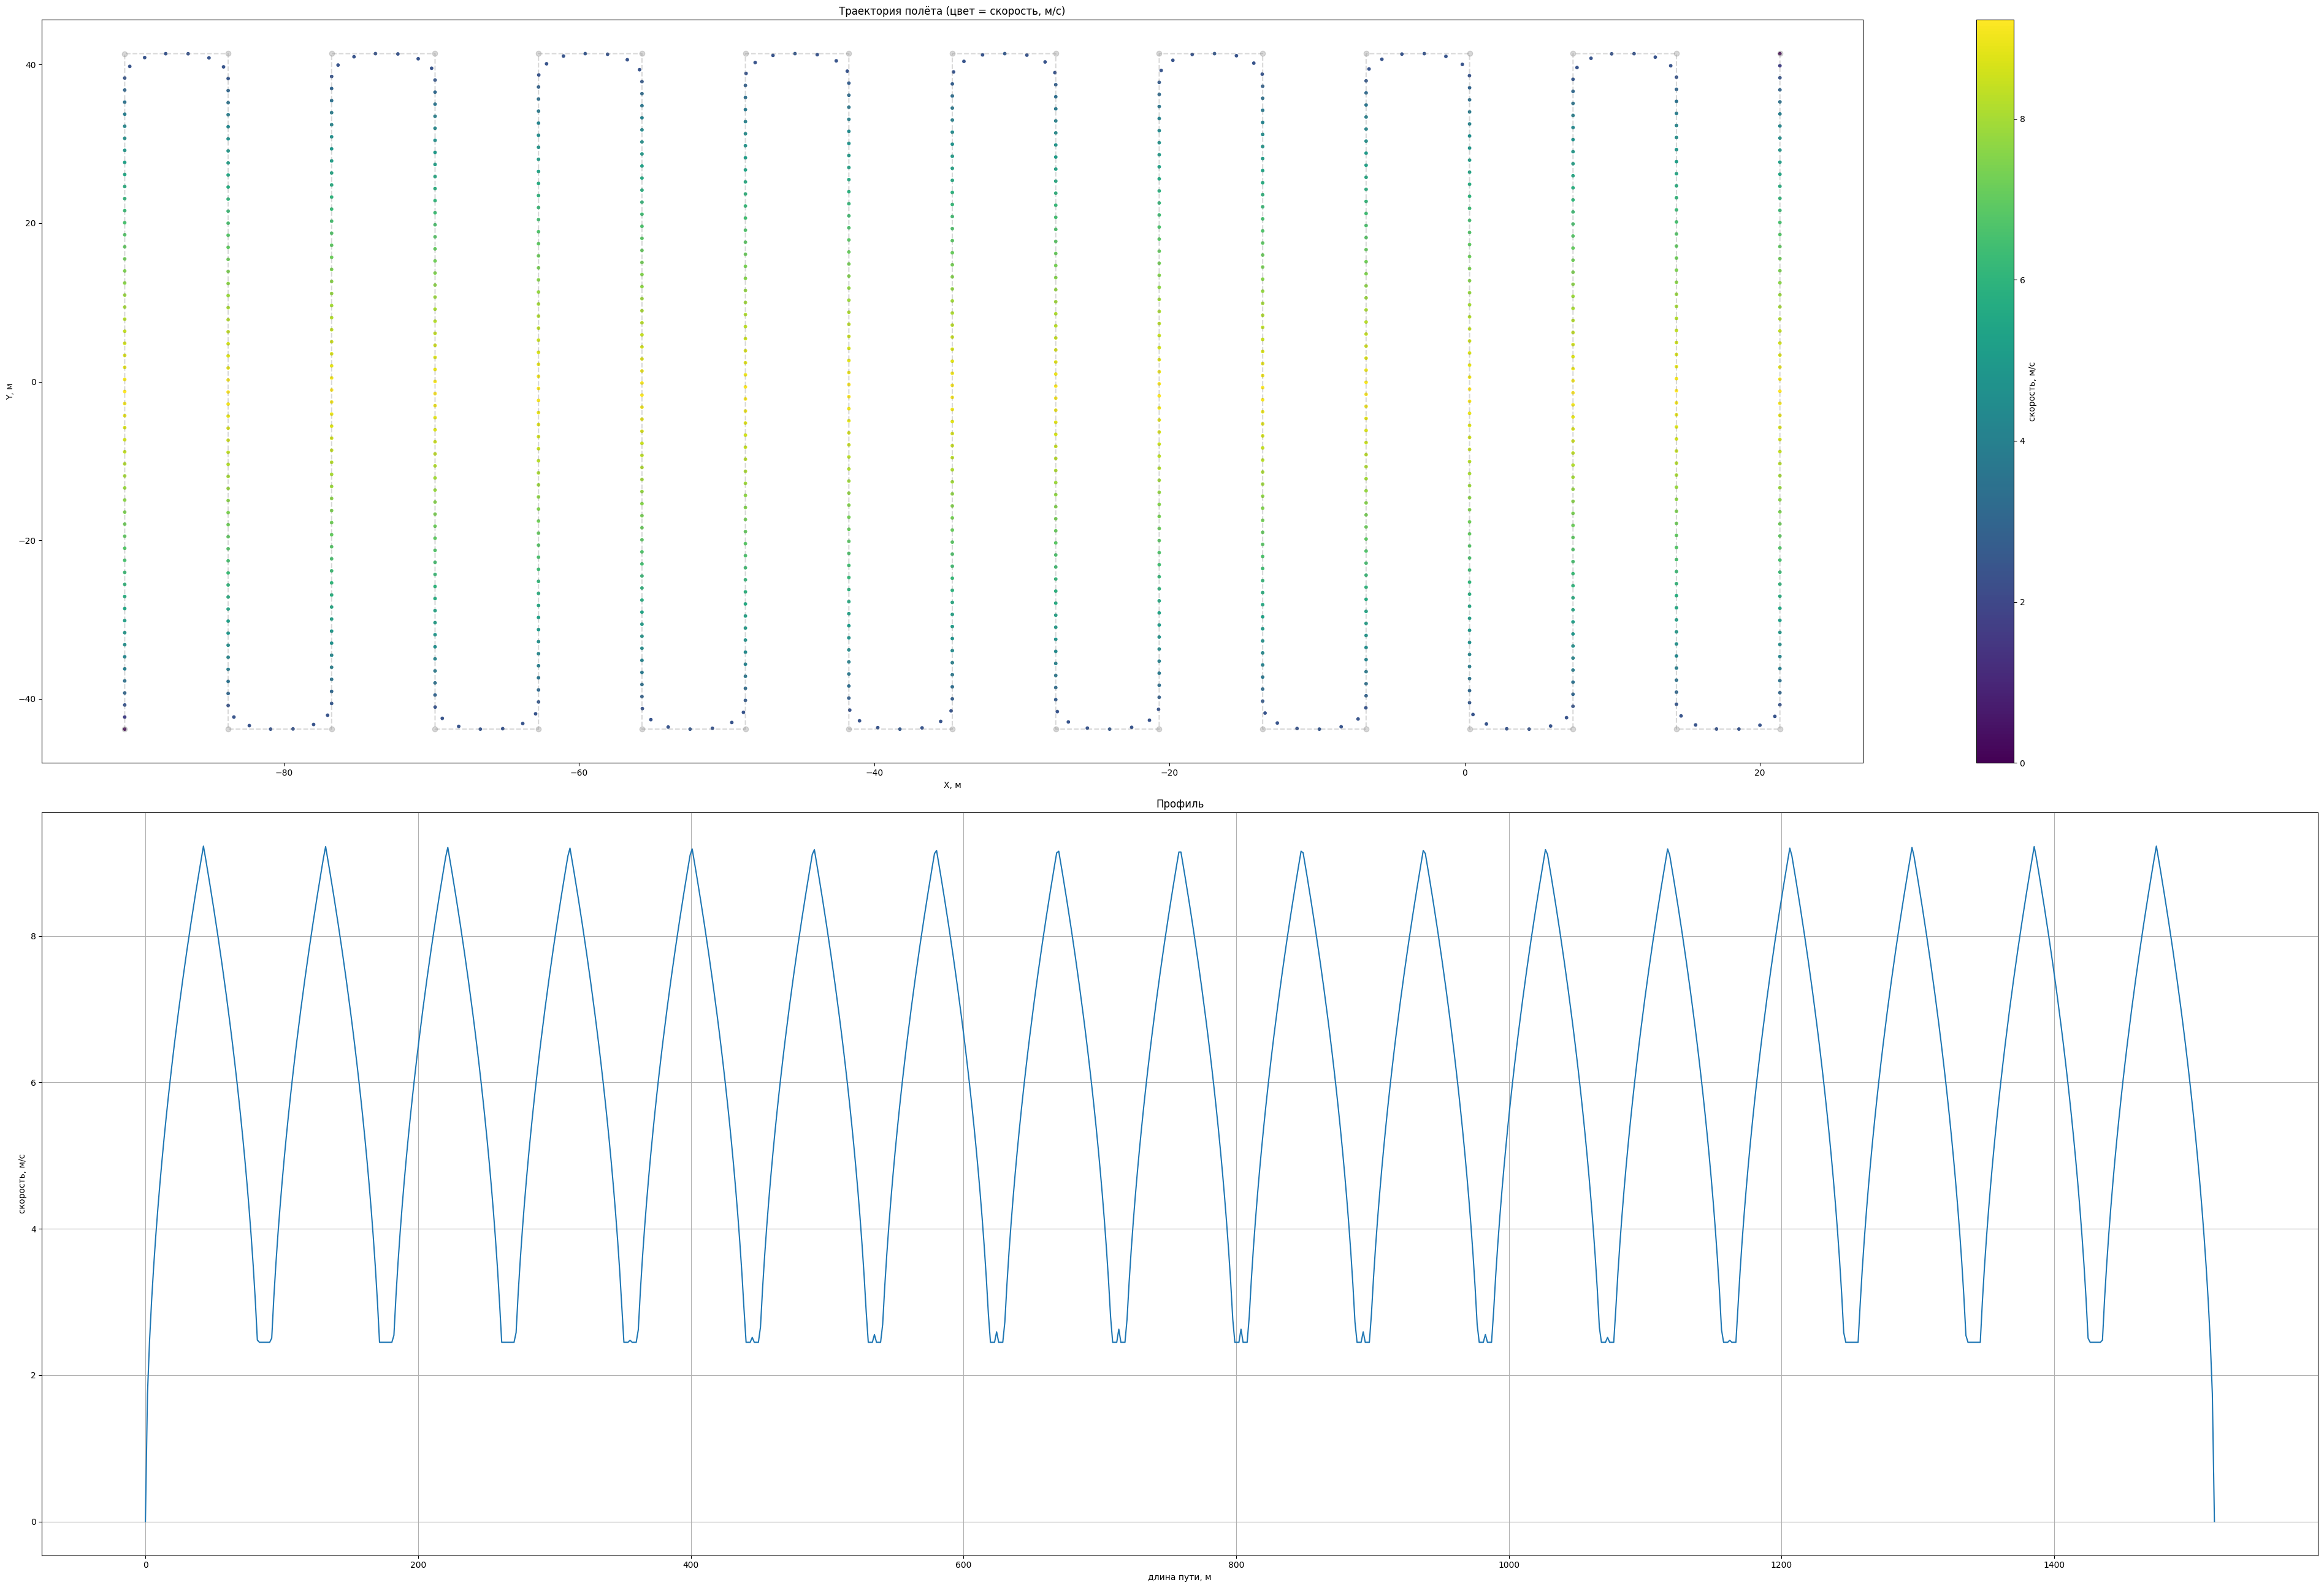

In [25]:
from plots import scatter_with_color_and_profile

profile_by_plan = predictor.build_profile(plan.waypoints_xy)

s_list = np.linspace(0, profile_by_plan.total_distance, 1000)
pts_list = [profile_by_plan.point_at_distance(s) for s in s_list]
speed_list = [profile_by_plan.speed_at_distance(s) for s in s_list]

scatter_with_color_and_profile(pts_list, speed_list, waypoints=plan.waypoints_xy)

In [7]:
tmp = (np.array(speed_list))

## Предсказанный режим работы насоса

In [36]:
from plots import plot_speeds_profile, plot_density_profile

t_list, s_list, speed_list = profile_by_plan.simulate_time_param(dt=0.01)

V_total = plan.calculate_total_volume(norma)  # л — нужно вылить на всём маршруте

pump_series_by_plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    length=profile_by_plan.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_plan.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_series_by_plan) :.2f} л")
empty_s_list = [profile_by_plan.distance_at_time(t) for t, v in pump_series_by_plan.empty_events]

if pump_series_by_plan.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_series_by_plan.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")

Длина маршрута L = 1519.00 м
Плановый объём V_total = 9.89 л
Фактически выльется (с учётом ограничений насоса): 9.98 л
Бак не опустошается в ходе полёта.


## Профили скоростей (дрон, насос)

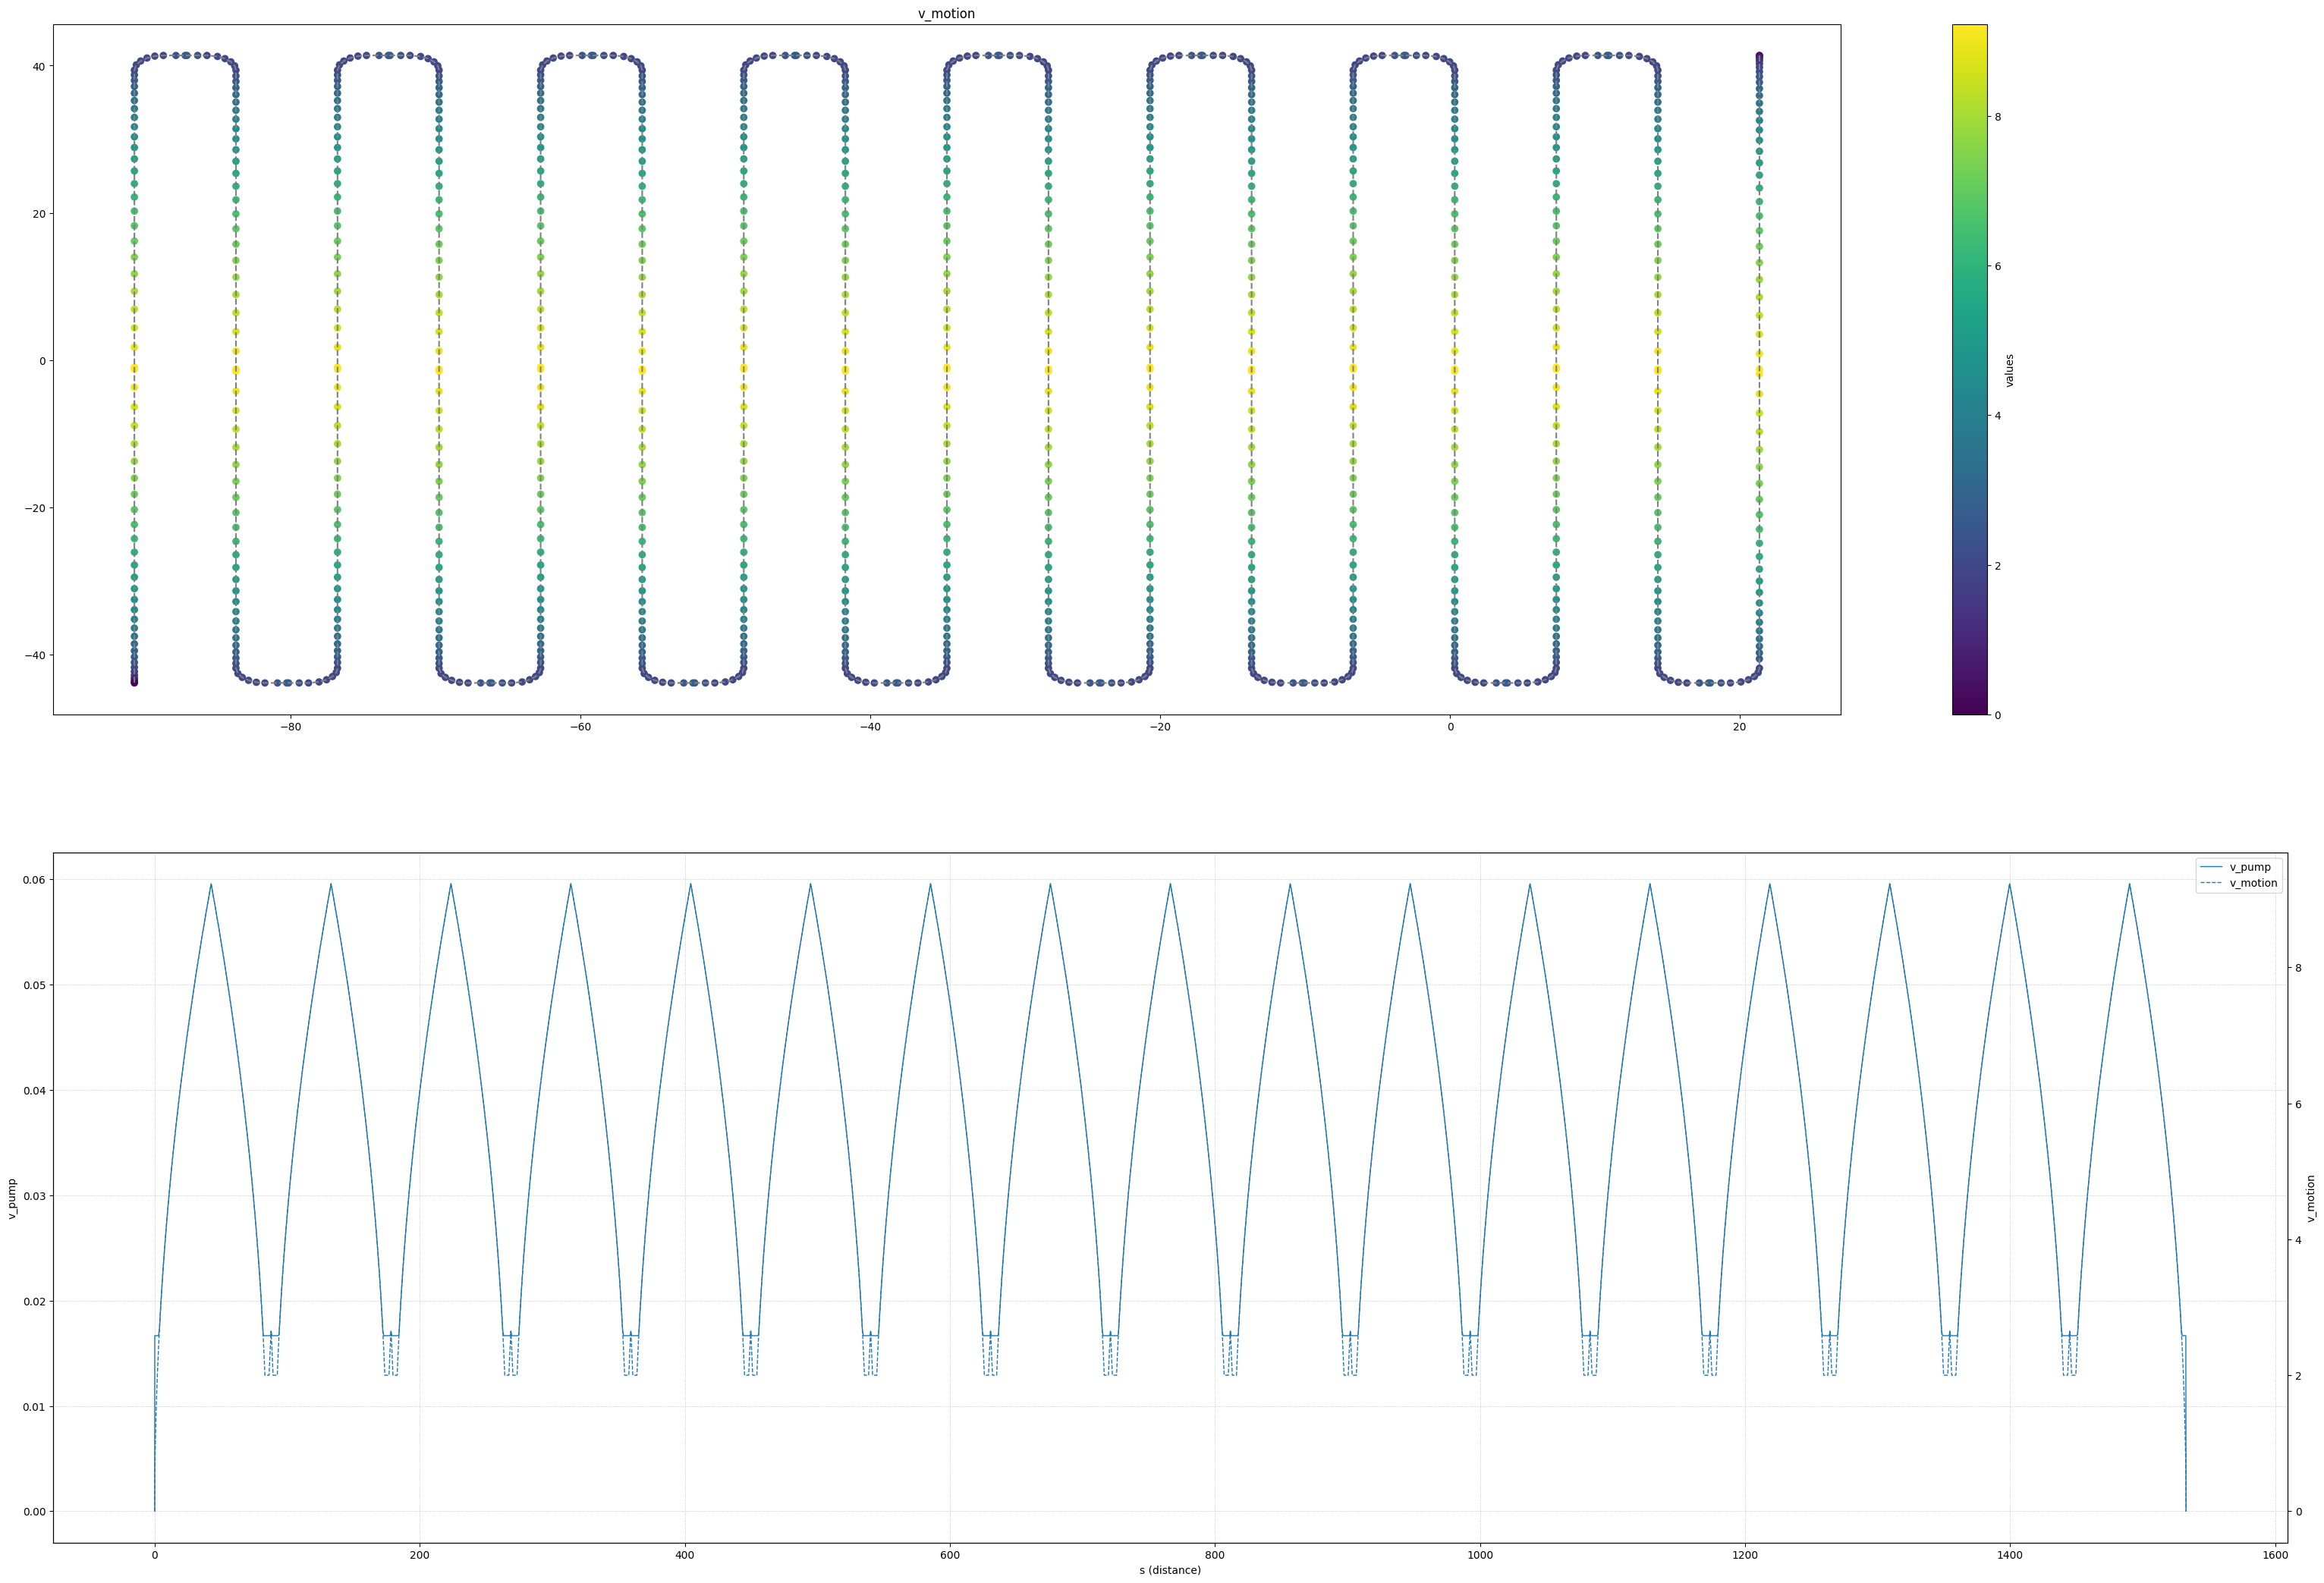

In [9]:
list_pts = [profile_by_plan.point_at_distance(s) for s in s_list]


plot_speeds_profile(list_pts,
                    s_list,
                    pump_series_by_plan.q,
                    speed_list,
                    empty_s_list)

## Плотность внесения

count    1086.000000
mean        0.006956
std         0.002021
min         0.000000
25%         0.006455
50%         0.006455
75%         0.006455
max         0.055556
dtype: float64
diff = 0.0005010501655693268
СКО = 4.329972920507831e-06


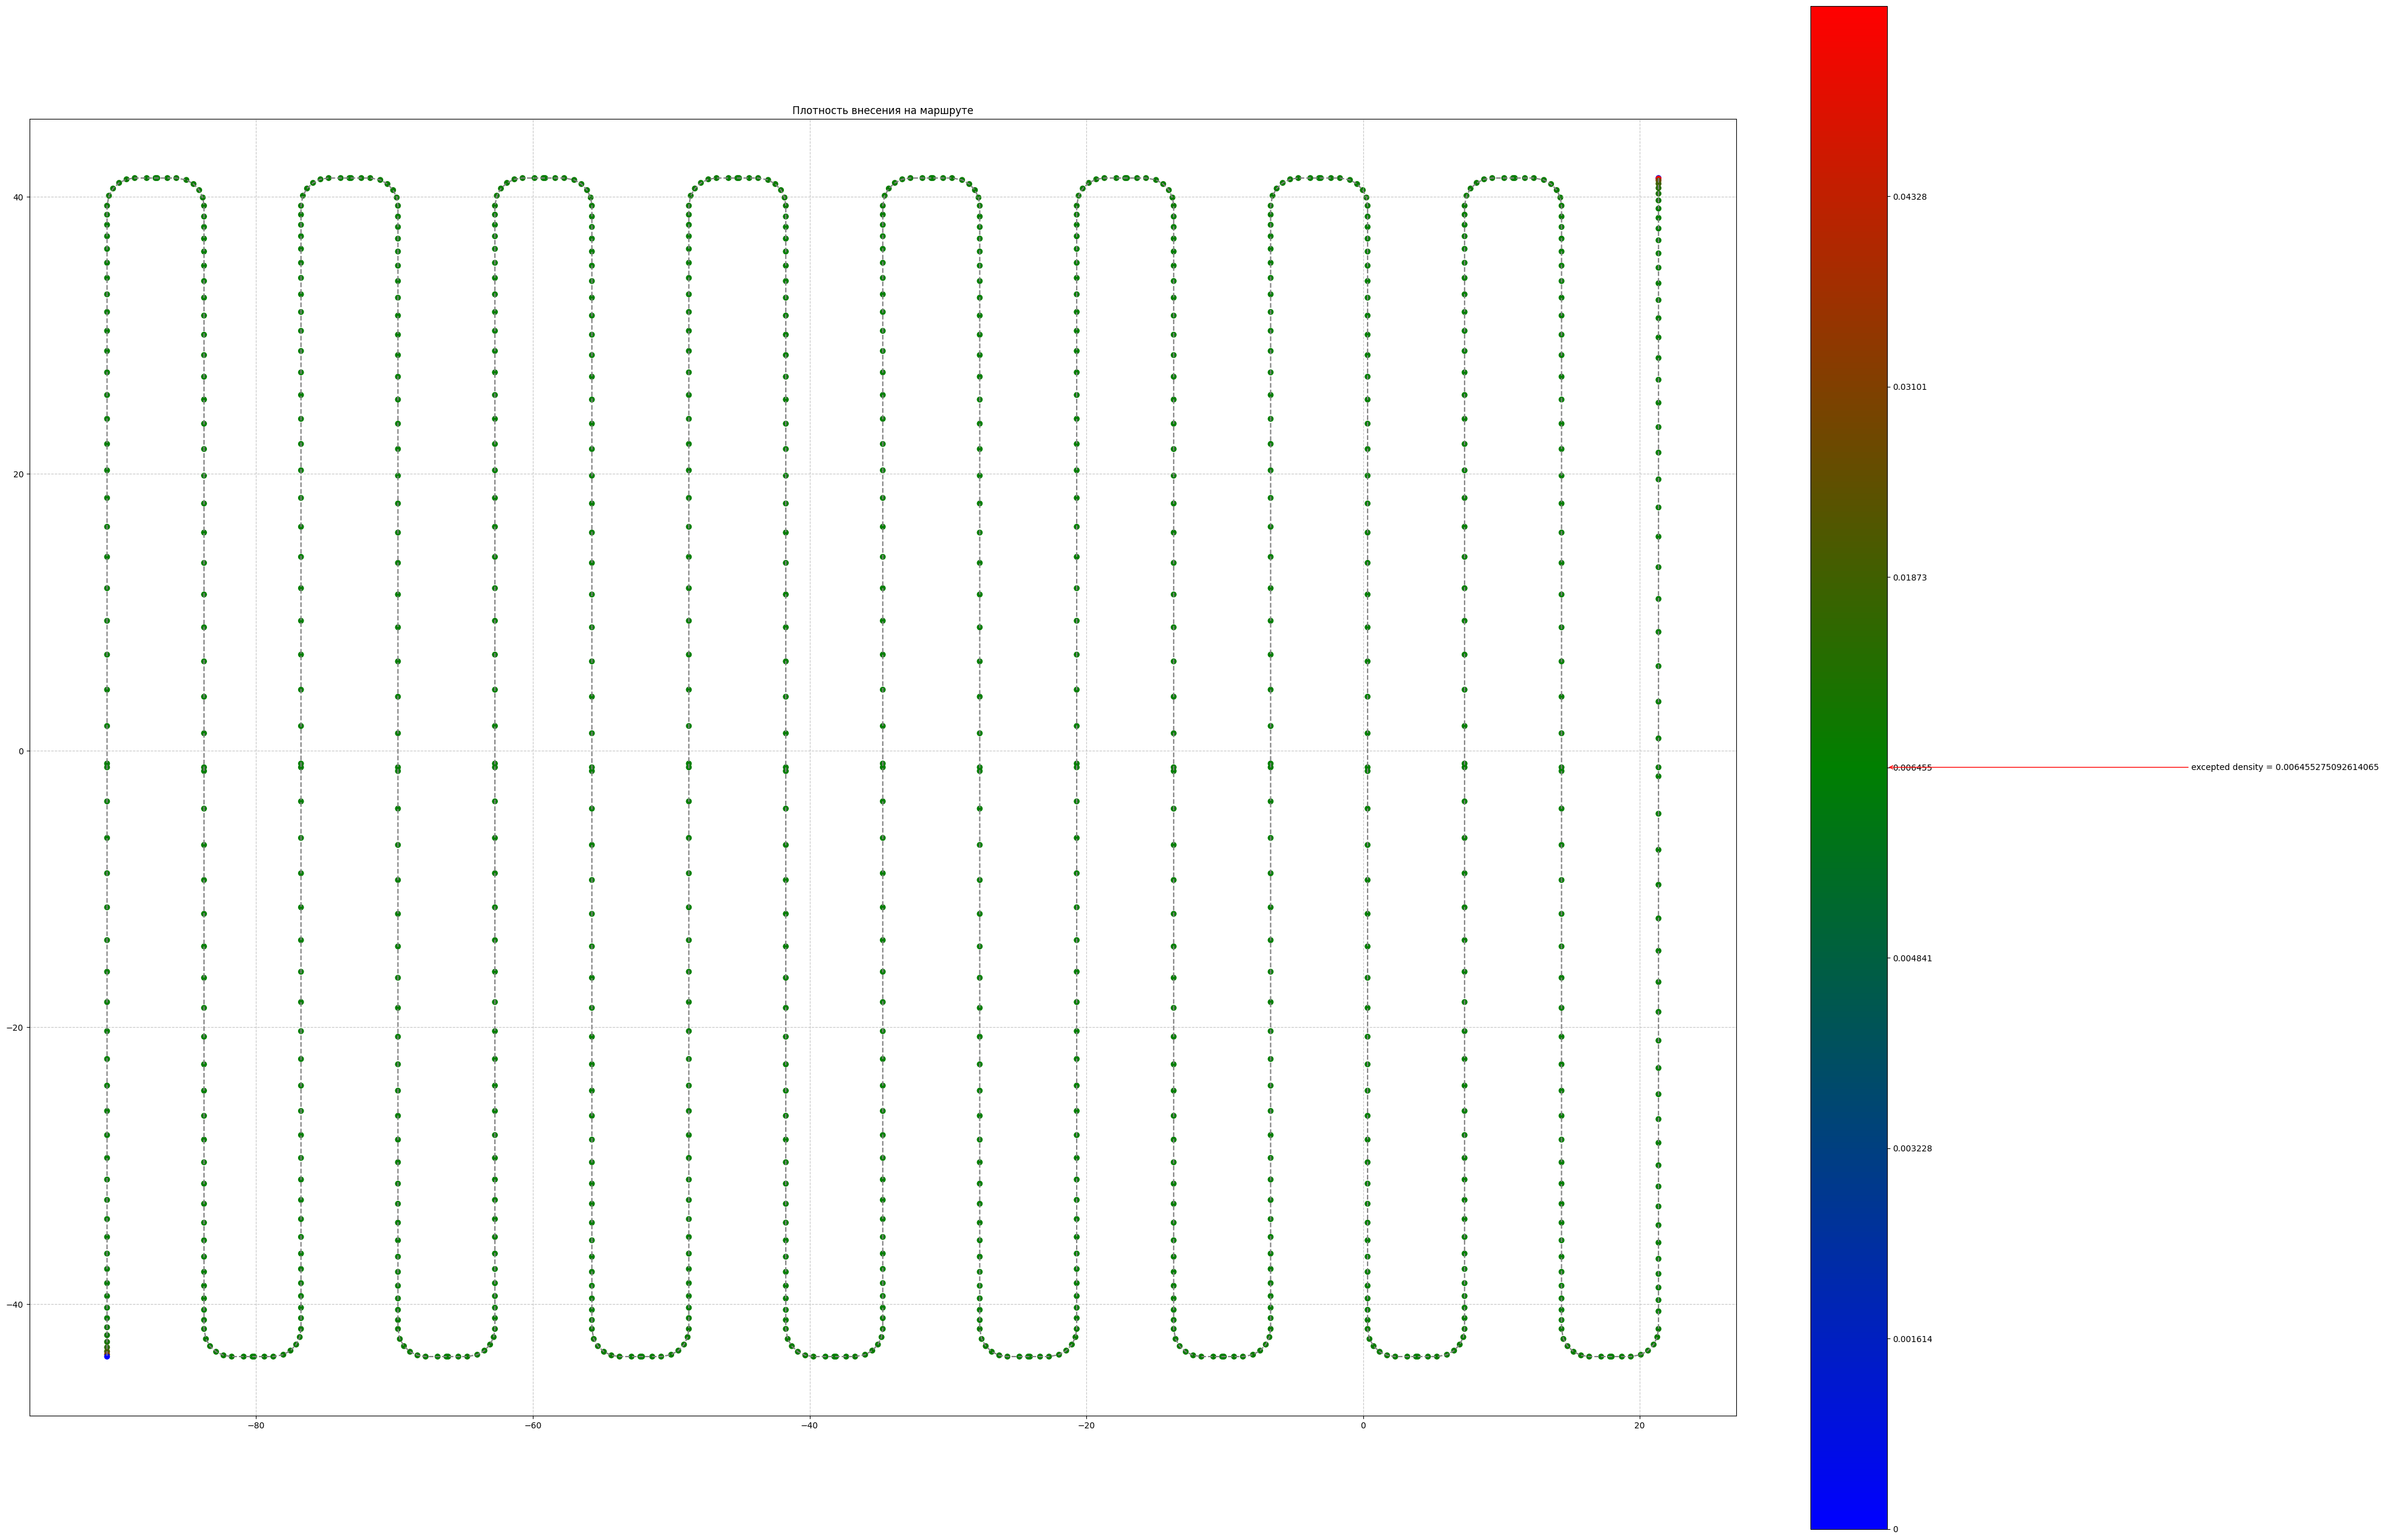

In [10]:
plot_density_profile(list_pts,
                     pump_series_by_plan.q,
                     speed_list,
                     V_total / profile_by_plan.total_distance)

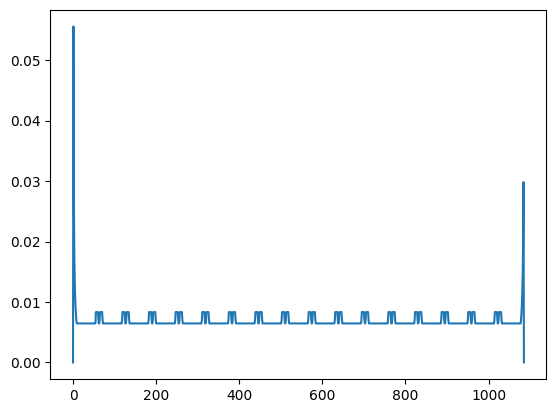

In [11]:
import matplotlib.pyplot as plt

l = PumpController.instantaneous_densities(speed_list, pump_series_by_plan.q)
plt.plot(l)

## Интегрируем, считаем вылитый объём и пройденный маршрут

In [12]:
from scipy import integrate

In [13]:
f = lambda t: pump_series_by_plan.q[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

10.205357632677 ± 0.09279914596466021


C:\Users\nodax\AppData\Local\Temp\ipykernel_8940\3940417807.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [14]:
import numpy as np

print(np.trapezoid(speed_list, pump_series_by_plan.t))

1532.7377390274892


In [15]:
from scipy.integrate import simpson

print(simpson(speed_list, x=pump_series_by_plan.t))

1532.7372043966216


In [16]:
plan.sum_distance_by_waypoints, profile_by_plan.total_distance

(1560.206774122365, 1532.7377390274896)

In [17]:
from scipy import interpolate, integrate

f = interpolate.interp1d(pump_series_by_plan.t, speed_list, kind="linear")  # или "cubic"
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

1534.9958025172725 ± 24.51048647460675


C:\Users\nodax\AppData\Local\Temp\ipykernel_8940\1325149867.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [18]:
f = lambda t: speed_list[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

1535.1515499118748 ± 67.60118271208489


C:\Users\nodax\AppData\Local\Temp\ipykernel_8940\547705918.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


# Берём данные о полёте из логов

## Визуализация всех полётов в лог файле

Полёт № 1


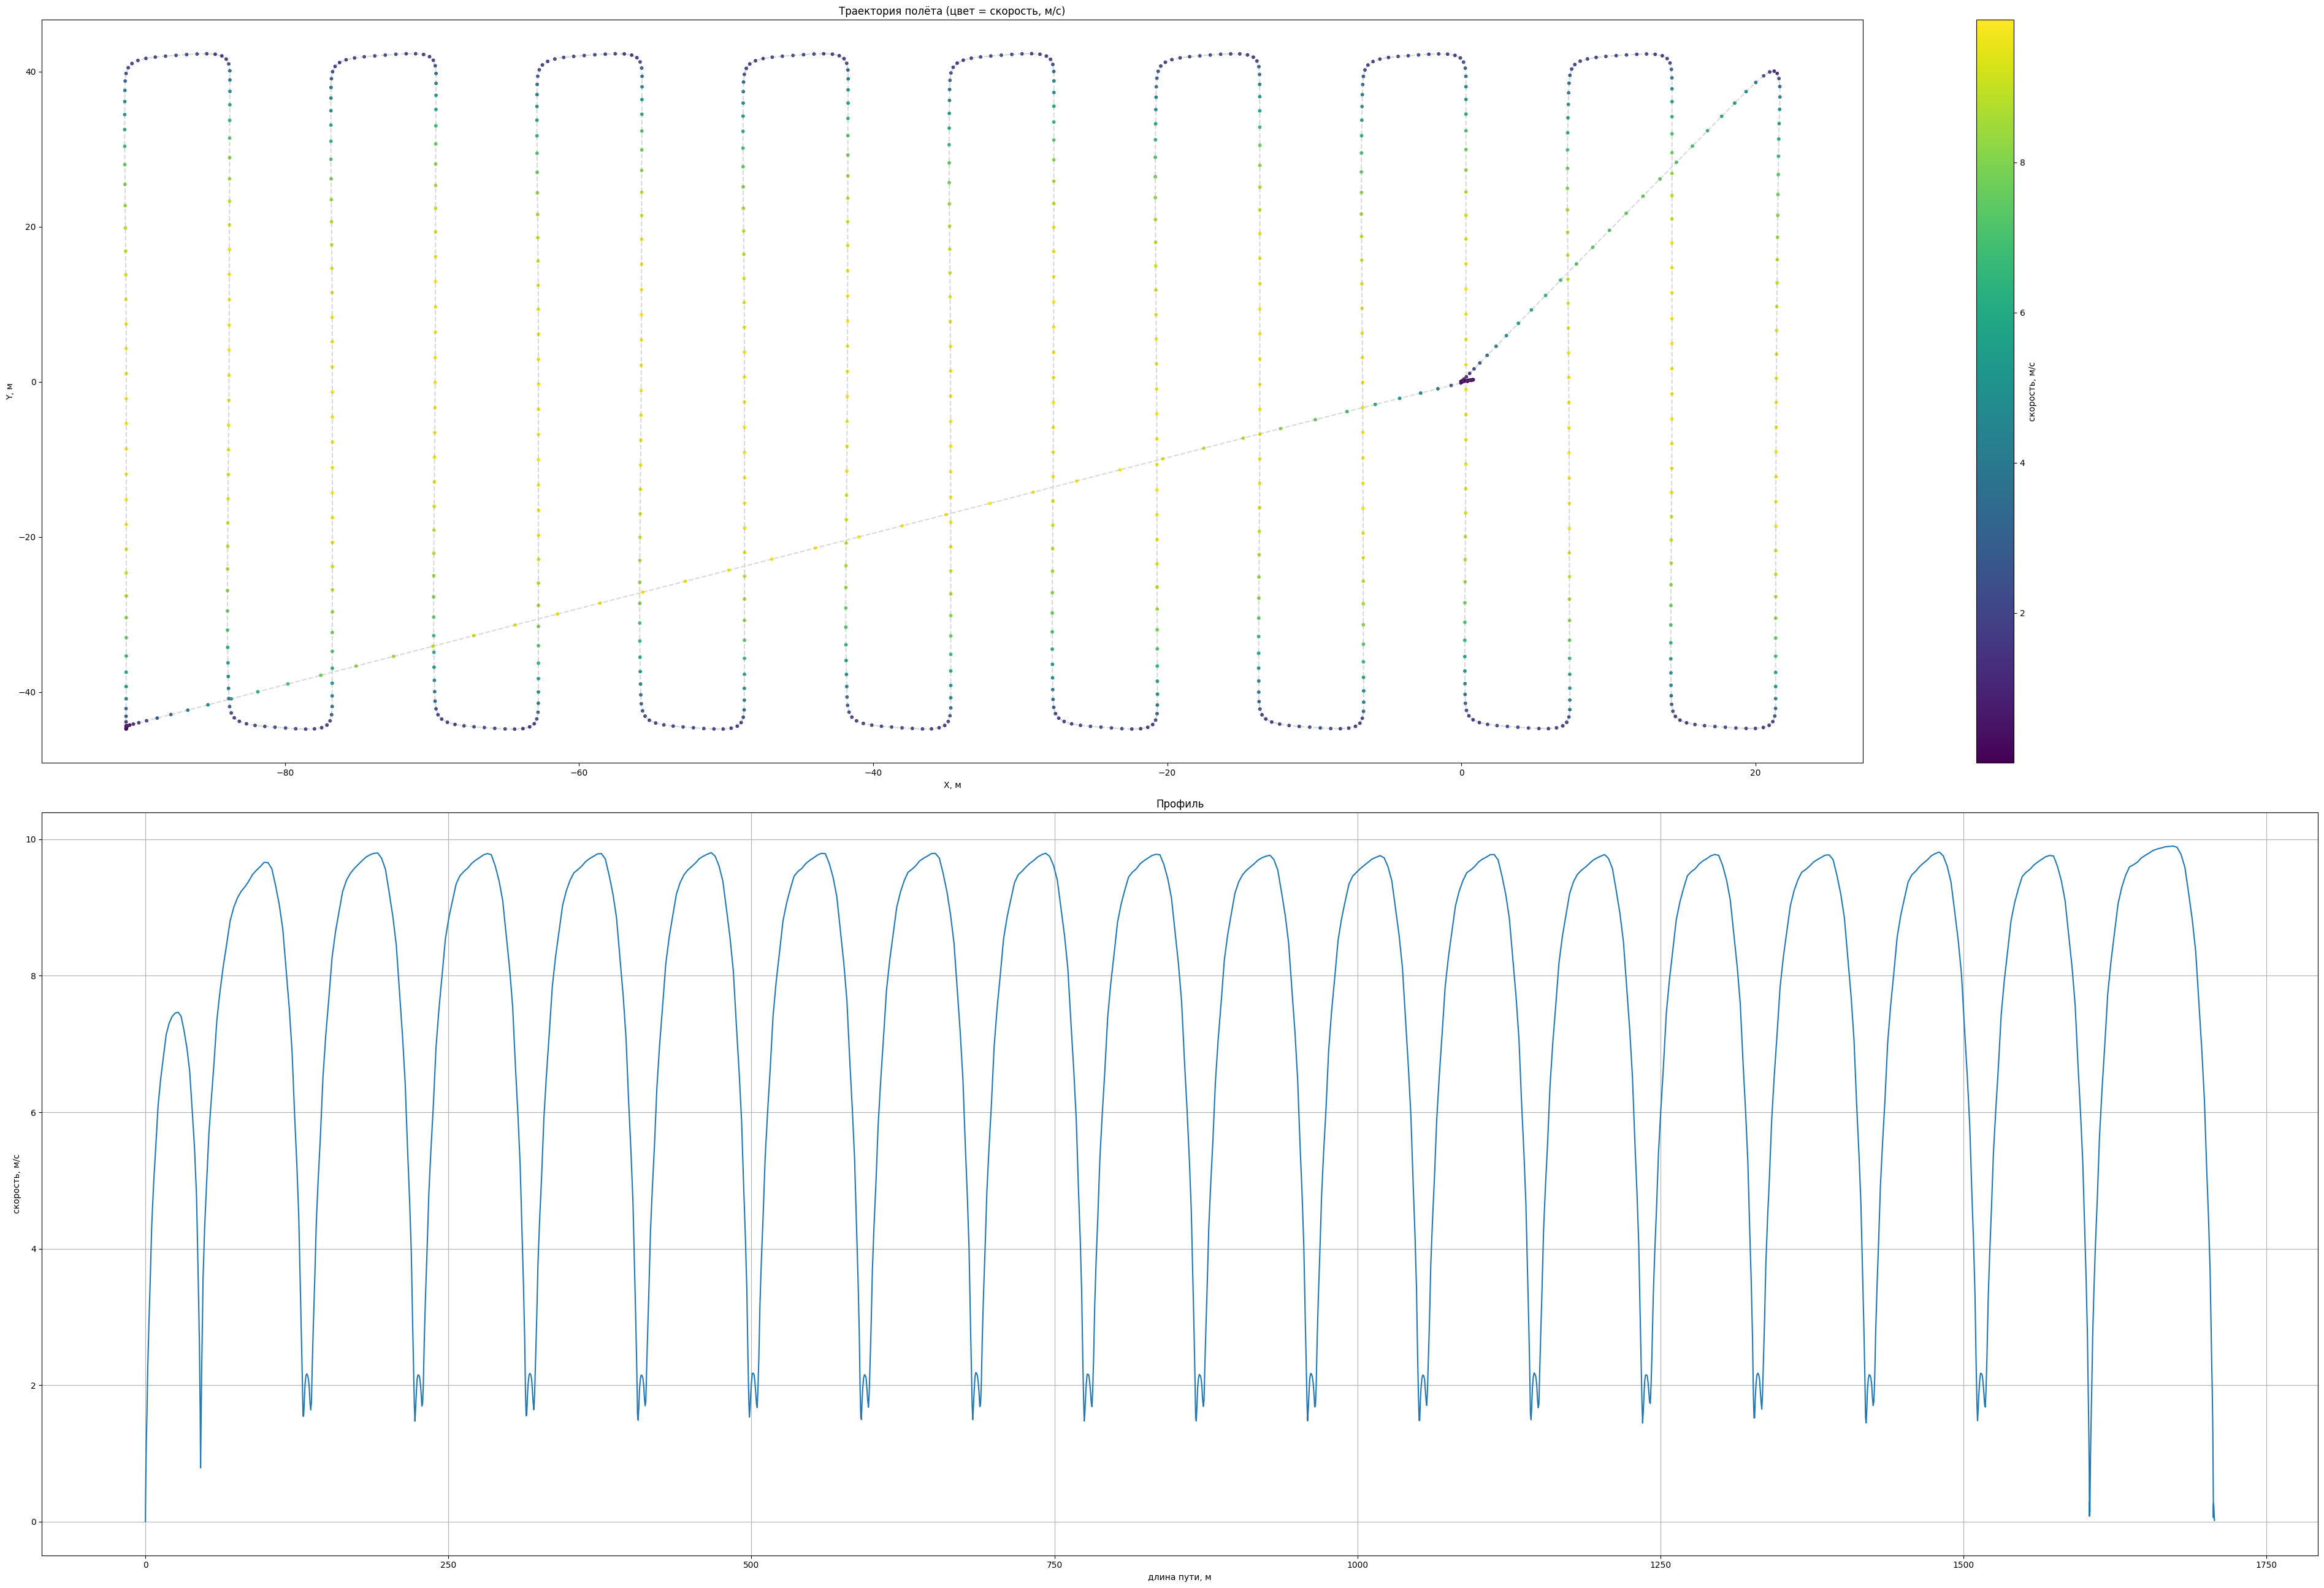

Полёт № 2


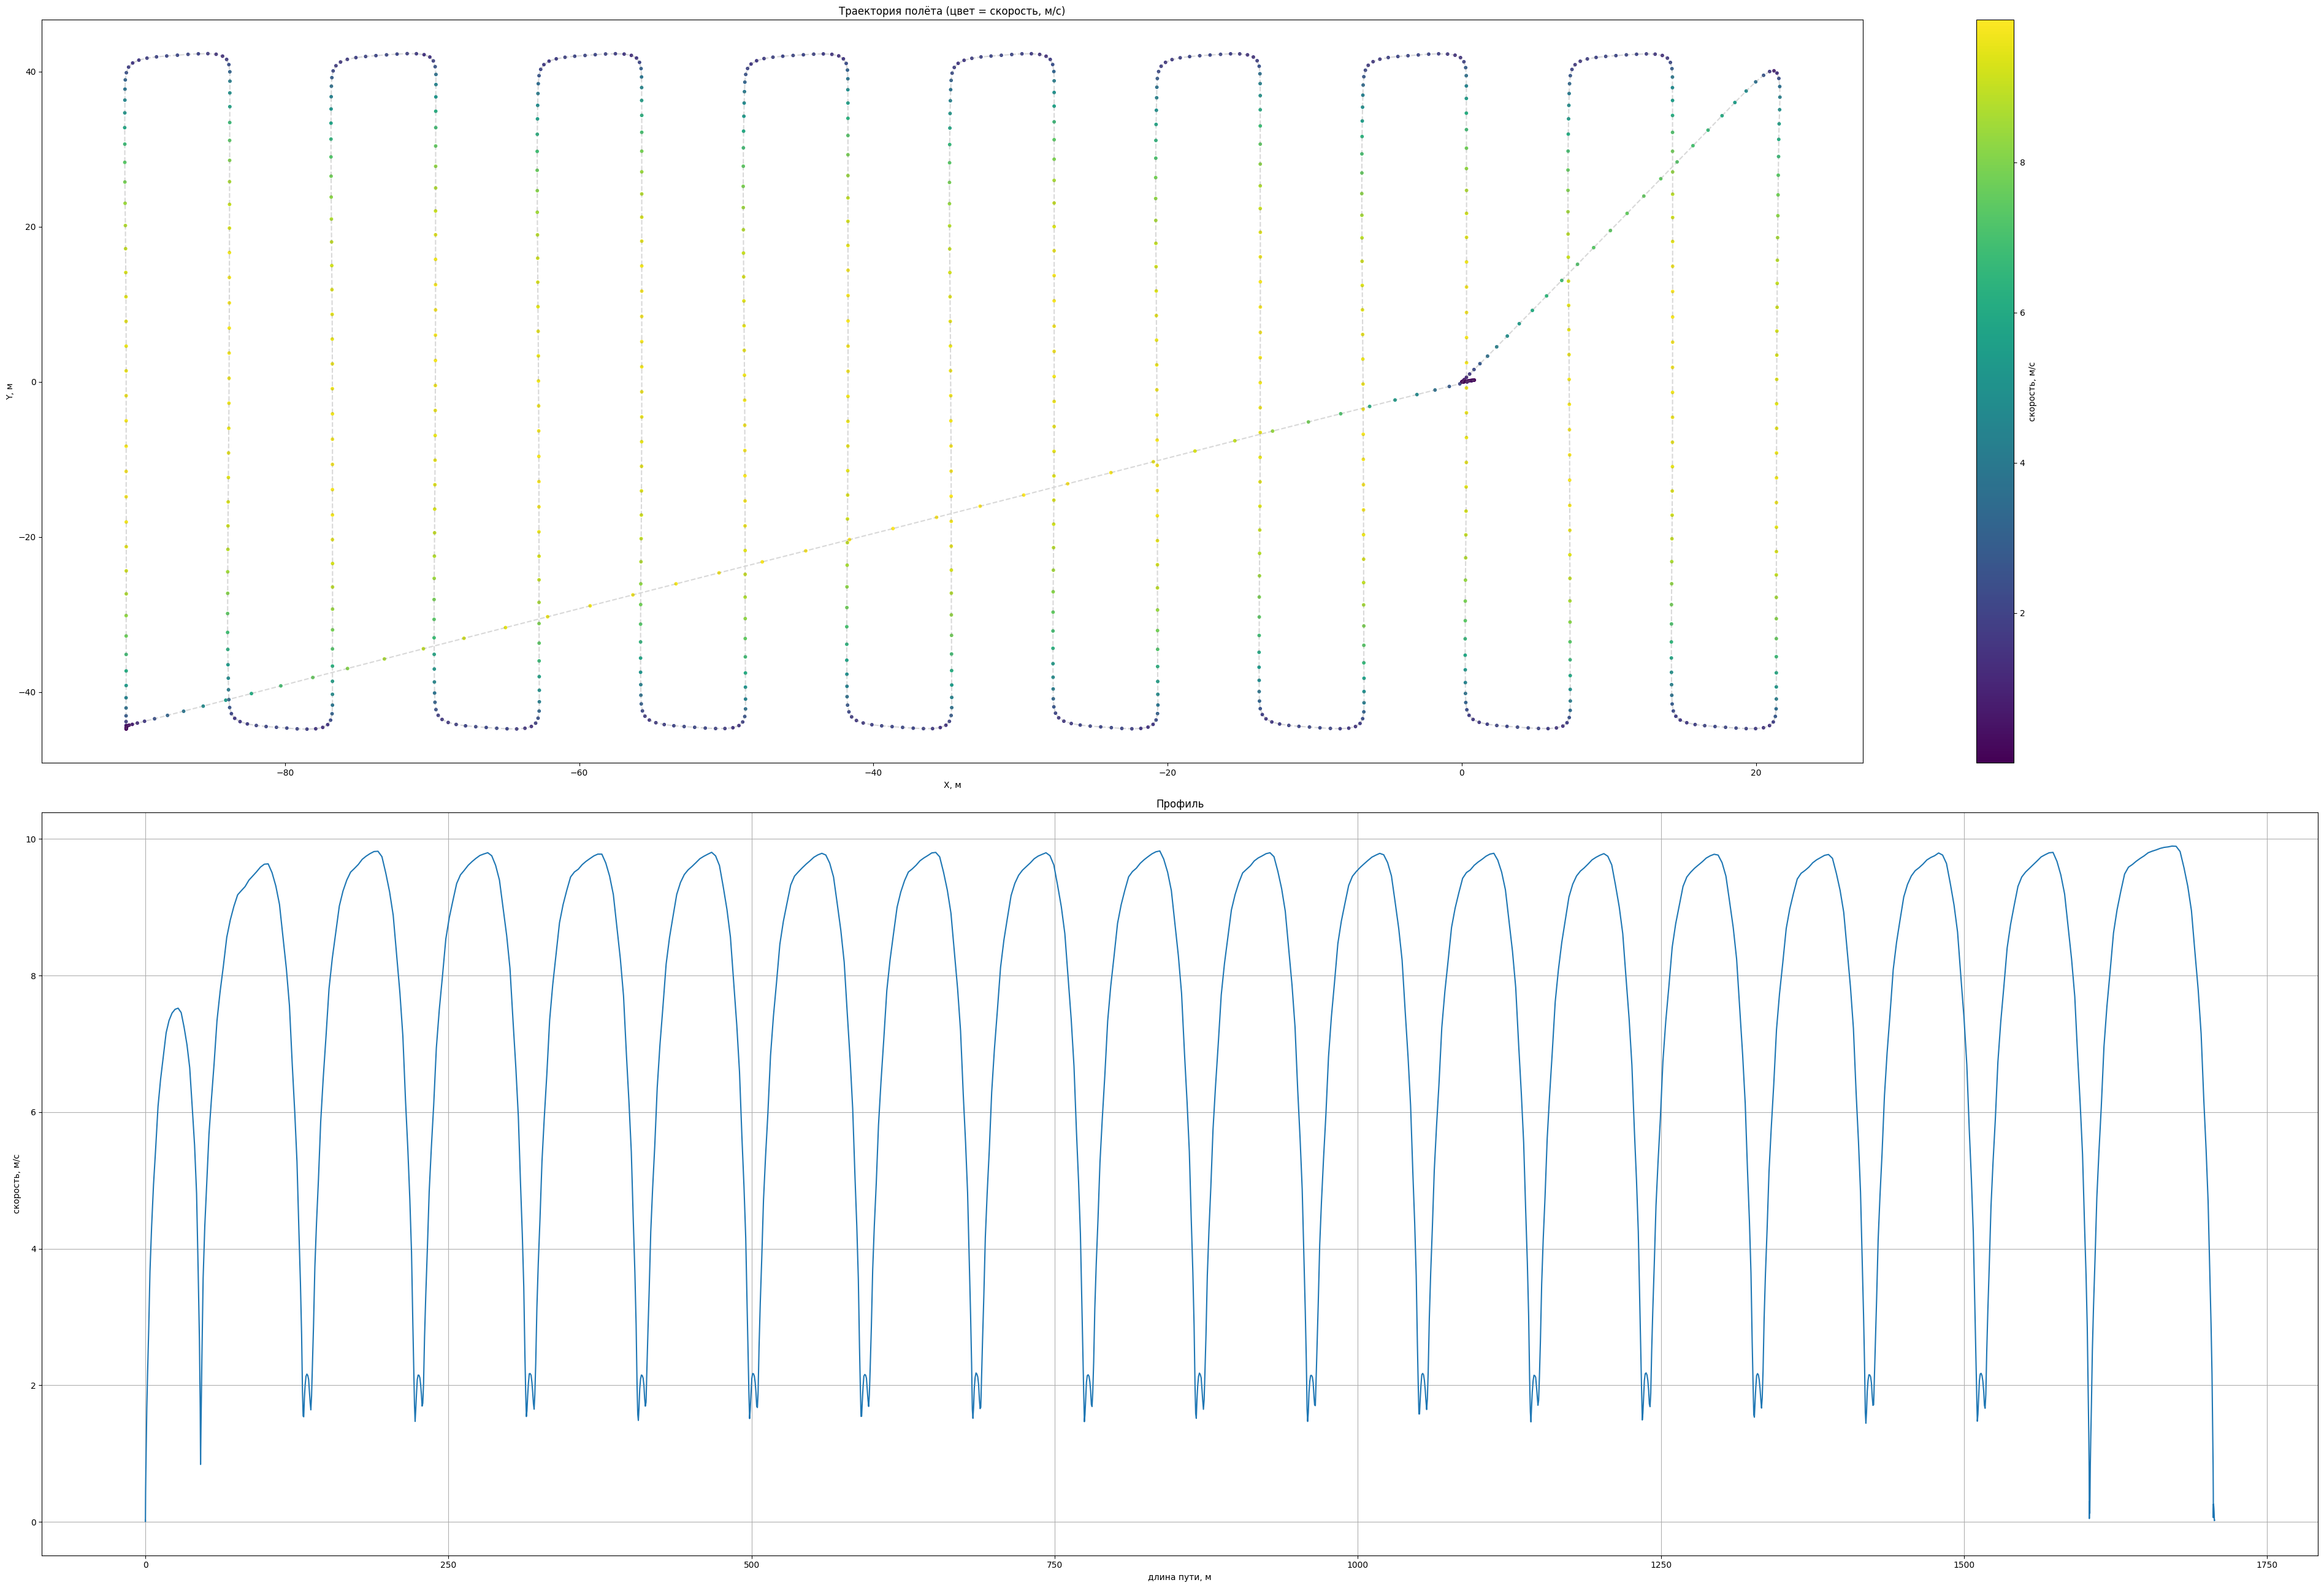

In [19]:
for i, f in enumerate(in_logs.flight_points, 1):
    print(f"Полёт № {i}")
    scatter_with_color_and_profile(f['points'], f['speed'])

## Берём один полёт для анализа

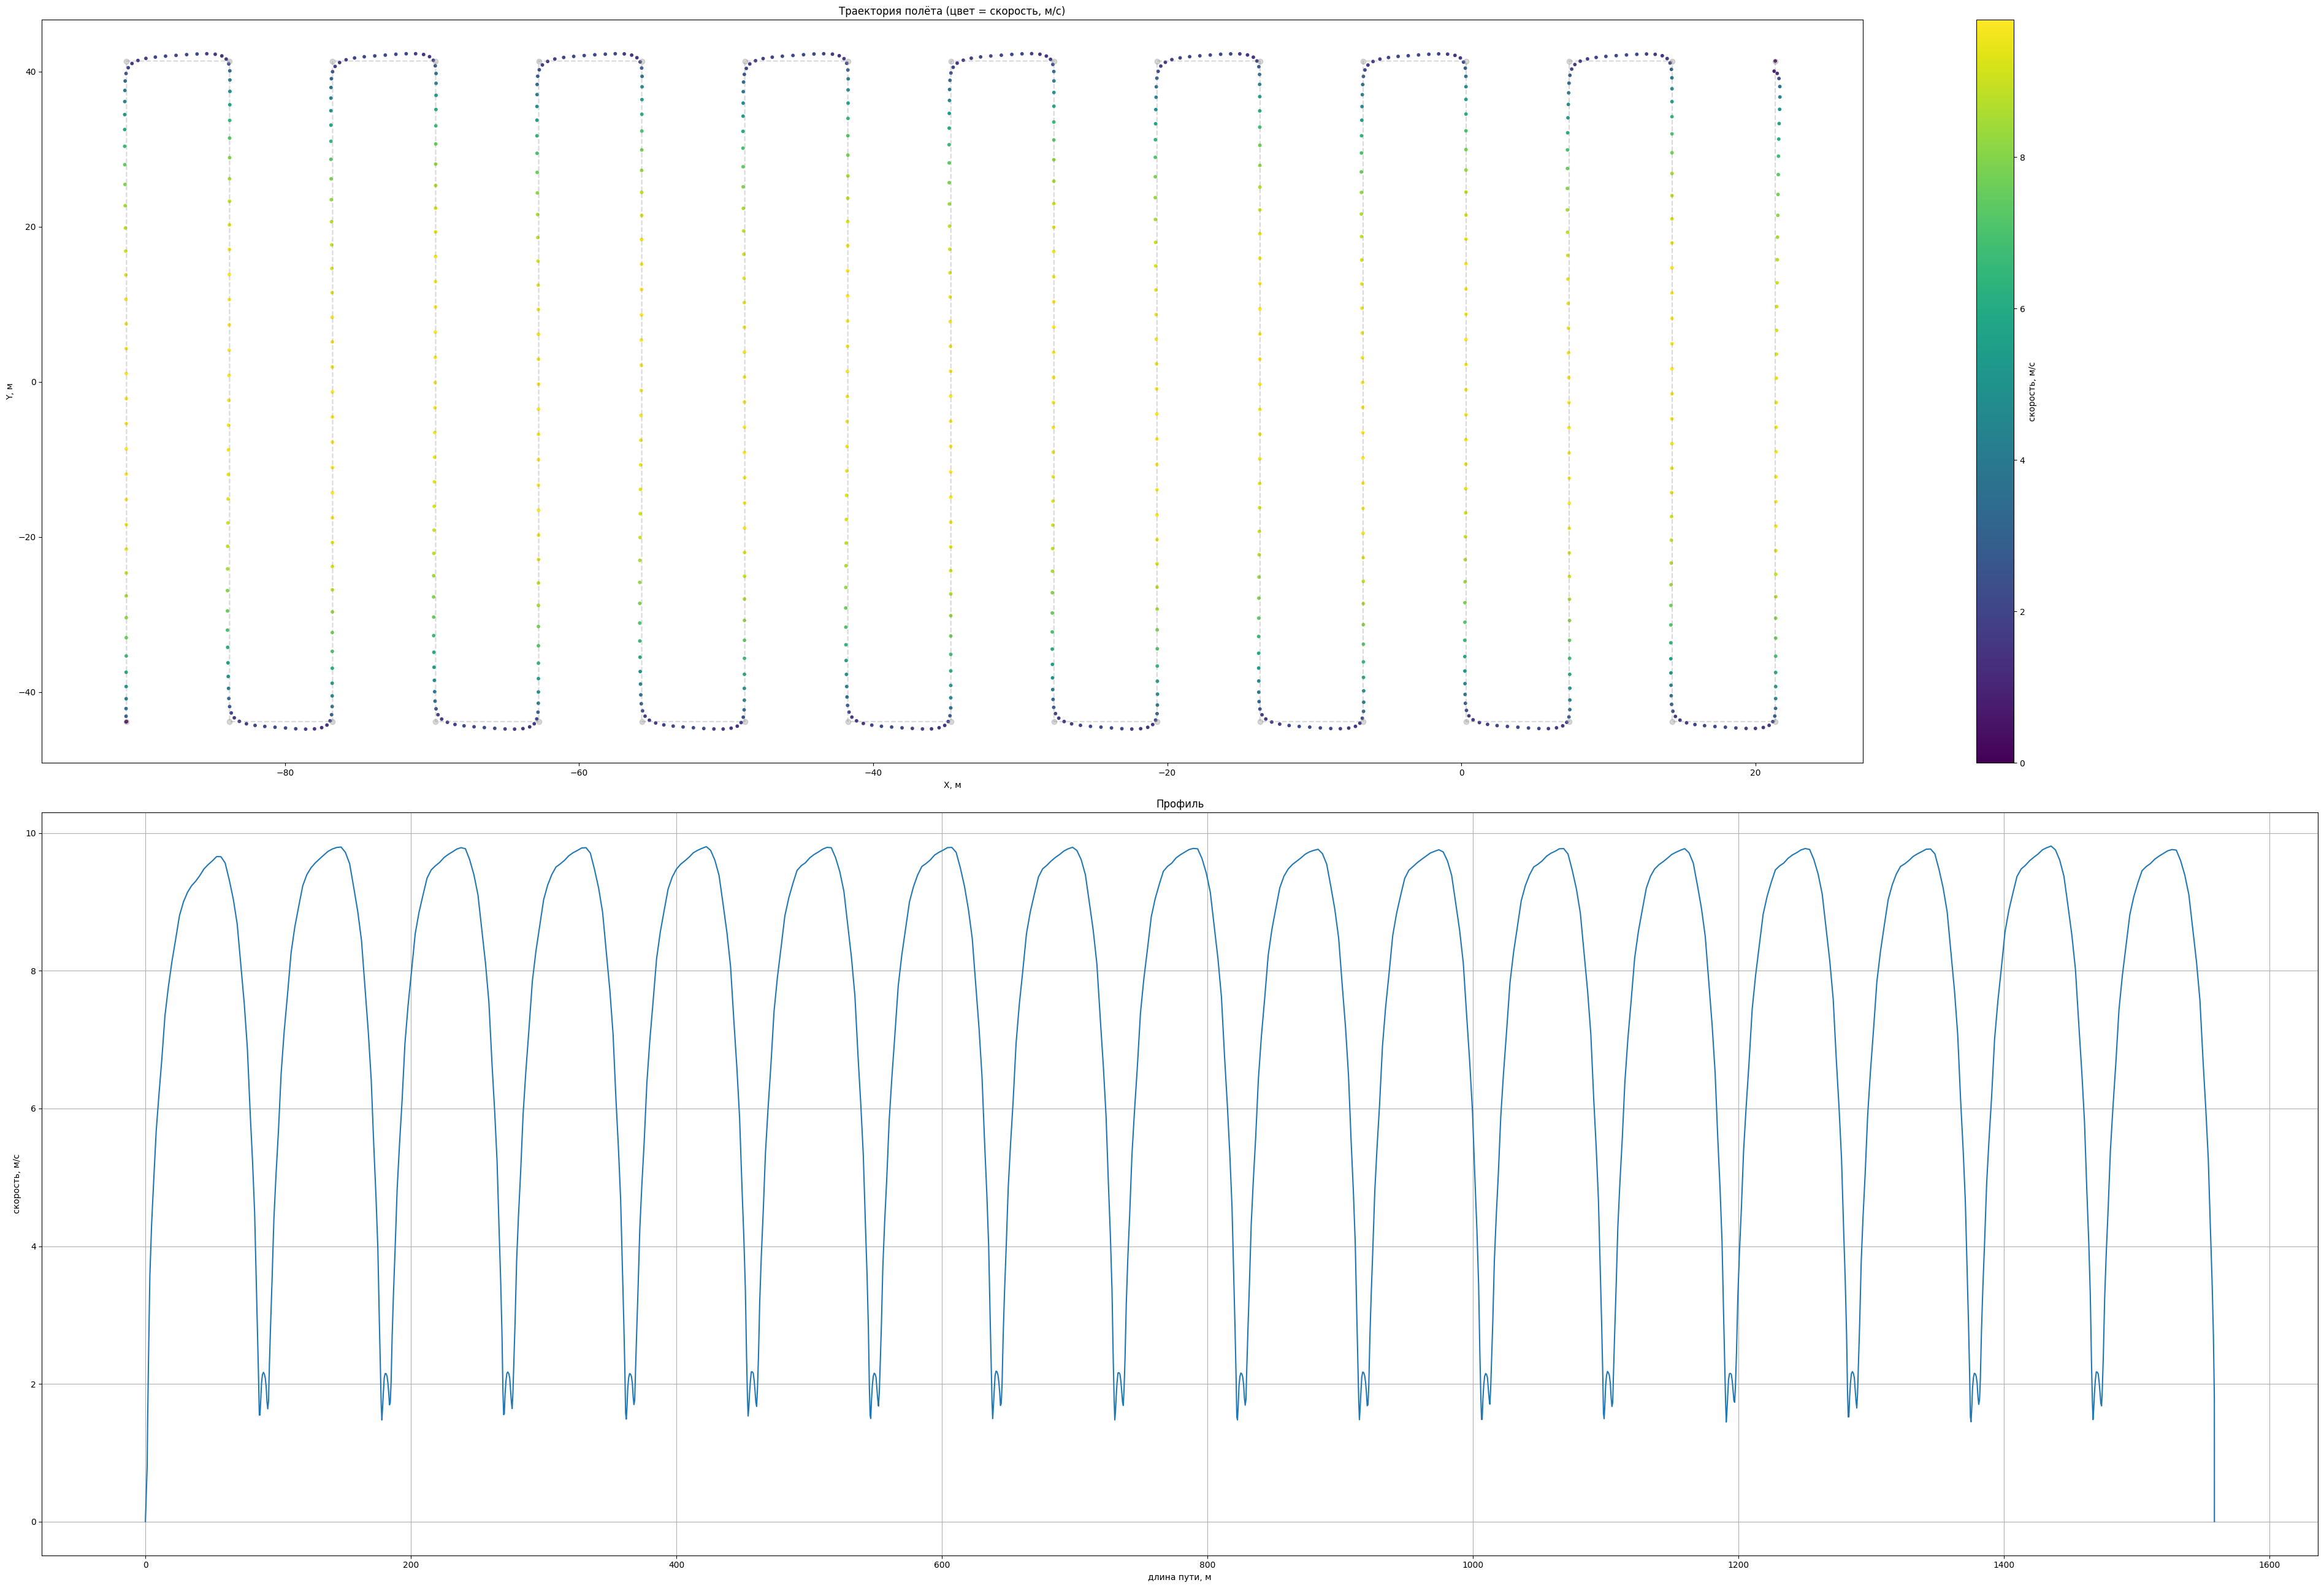

In [38]:
waypoints_by_logs, speed_list_by_logs = in_logs.get_waypoints_and_speed_list(index_fly=0)
scatter_with_color_and_profile(waypoints_by_logs, speed_list_by_logs, waypoints=plan.waypoints_xy)

## Предсказанный на основе логов

In [37]:
t_list = simulate_time_param(waypoints_by_logs, speed_list_by_logs)
profile_by_logs = predictor.build_profile(waypoints_by_logs)

pump_plan_by_logs = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list_by_logs,
    length=profile_by_logs.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_logs.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_plan_by_logs) :.2f} л")
empty_s_list = [profile_by_logs.distance_at_time(t) for t, v in pump_plan_by_logs.empty_events]

if pump_plan_by_logs.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_plan_by_logs.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")


Длина маршрута L = 1558.63 м
Плановый объём V_total = 9.89 л
Фактически выльется (с учётом ограничений насоса): 10.24 л
Бак не опустошается в ходе полёта.


## Профиль скорости

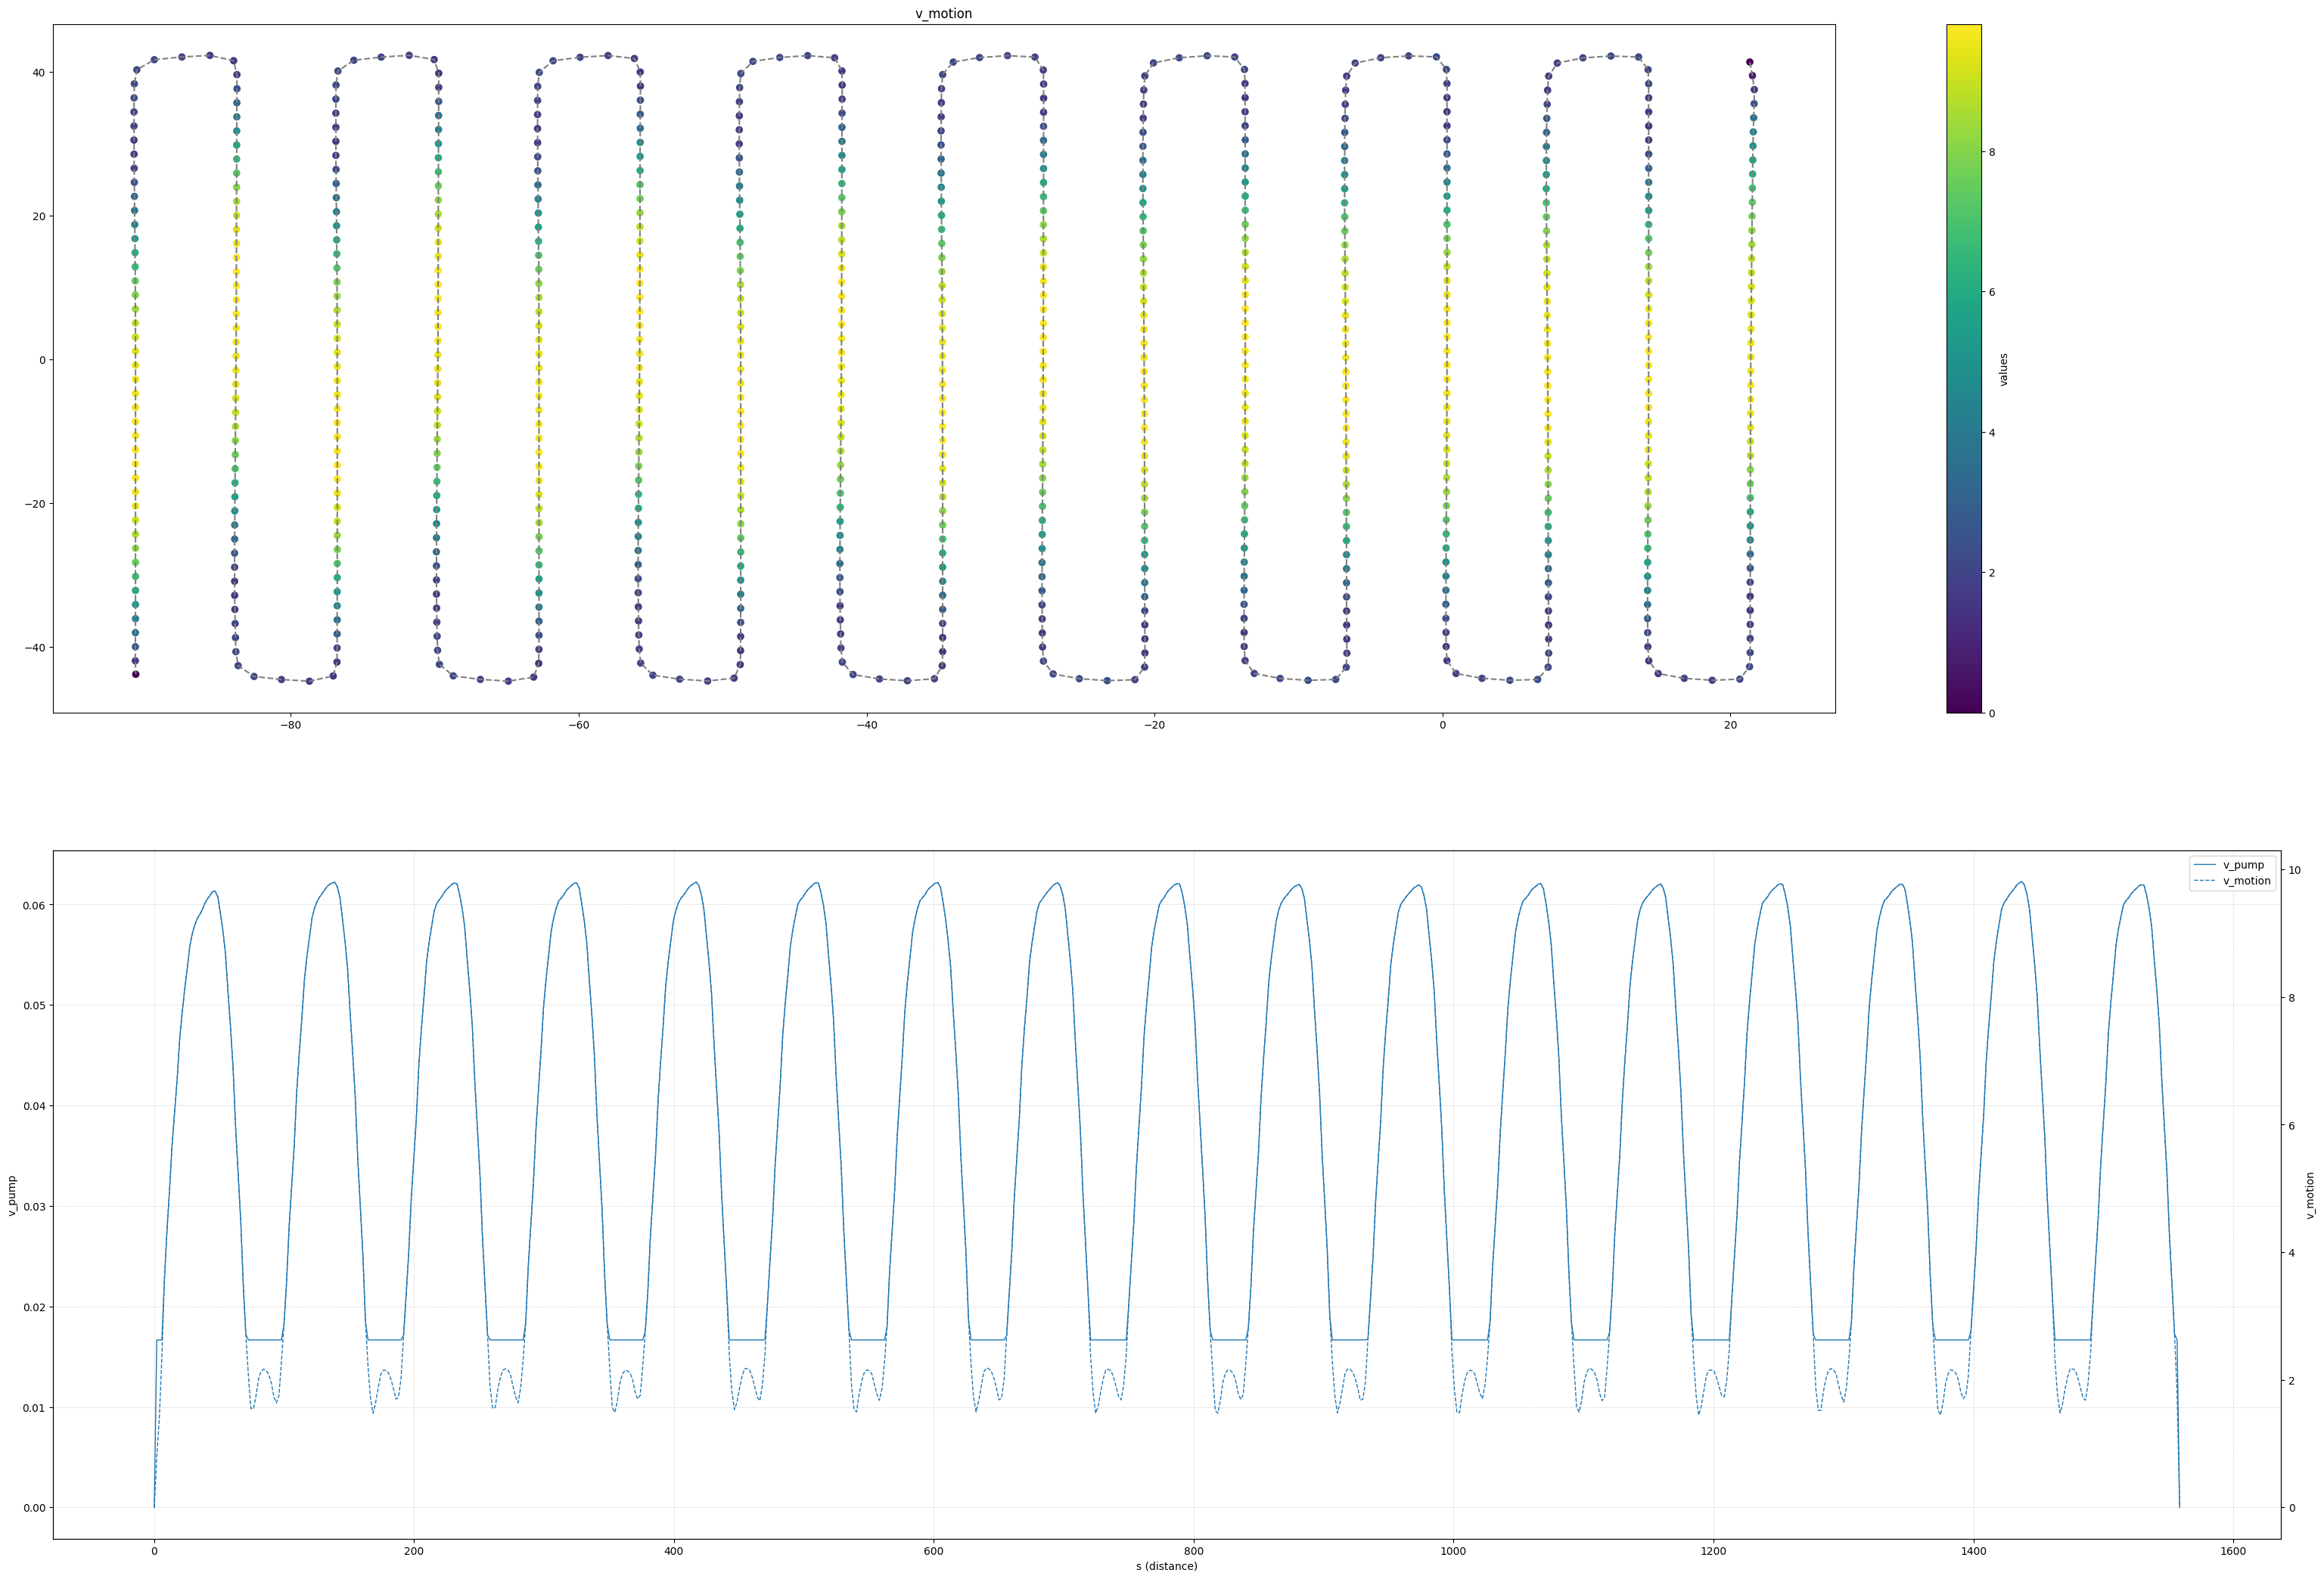

In [34]:
s_list_by_logs = np.linspace(0, profile_by_logs.total_distance, len(waypoints_by_logs))

list_pts = [profile_by_logs.point_at_distance(s) for s in s_list_by_logs]

plot_speeds_profile(list_pts,
                    s_list_by_logs,
                    pump_plan_by_logs.q,
                    speed_list_by_logs,
                    empty_s_list)

## Плотность внесения

count    797.000000
mean       0.007066
std        0.001425
min        0.000000
25%        0.006348
50%        0.006348
75%        0.007688
max        0.021128
dtype: float64
diff = 0.0007185277691318728
СКО = 2.5450199603304027e-06


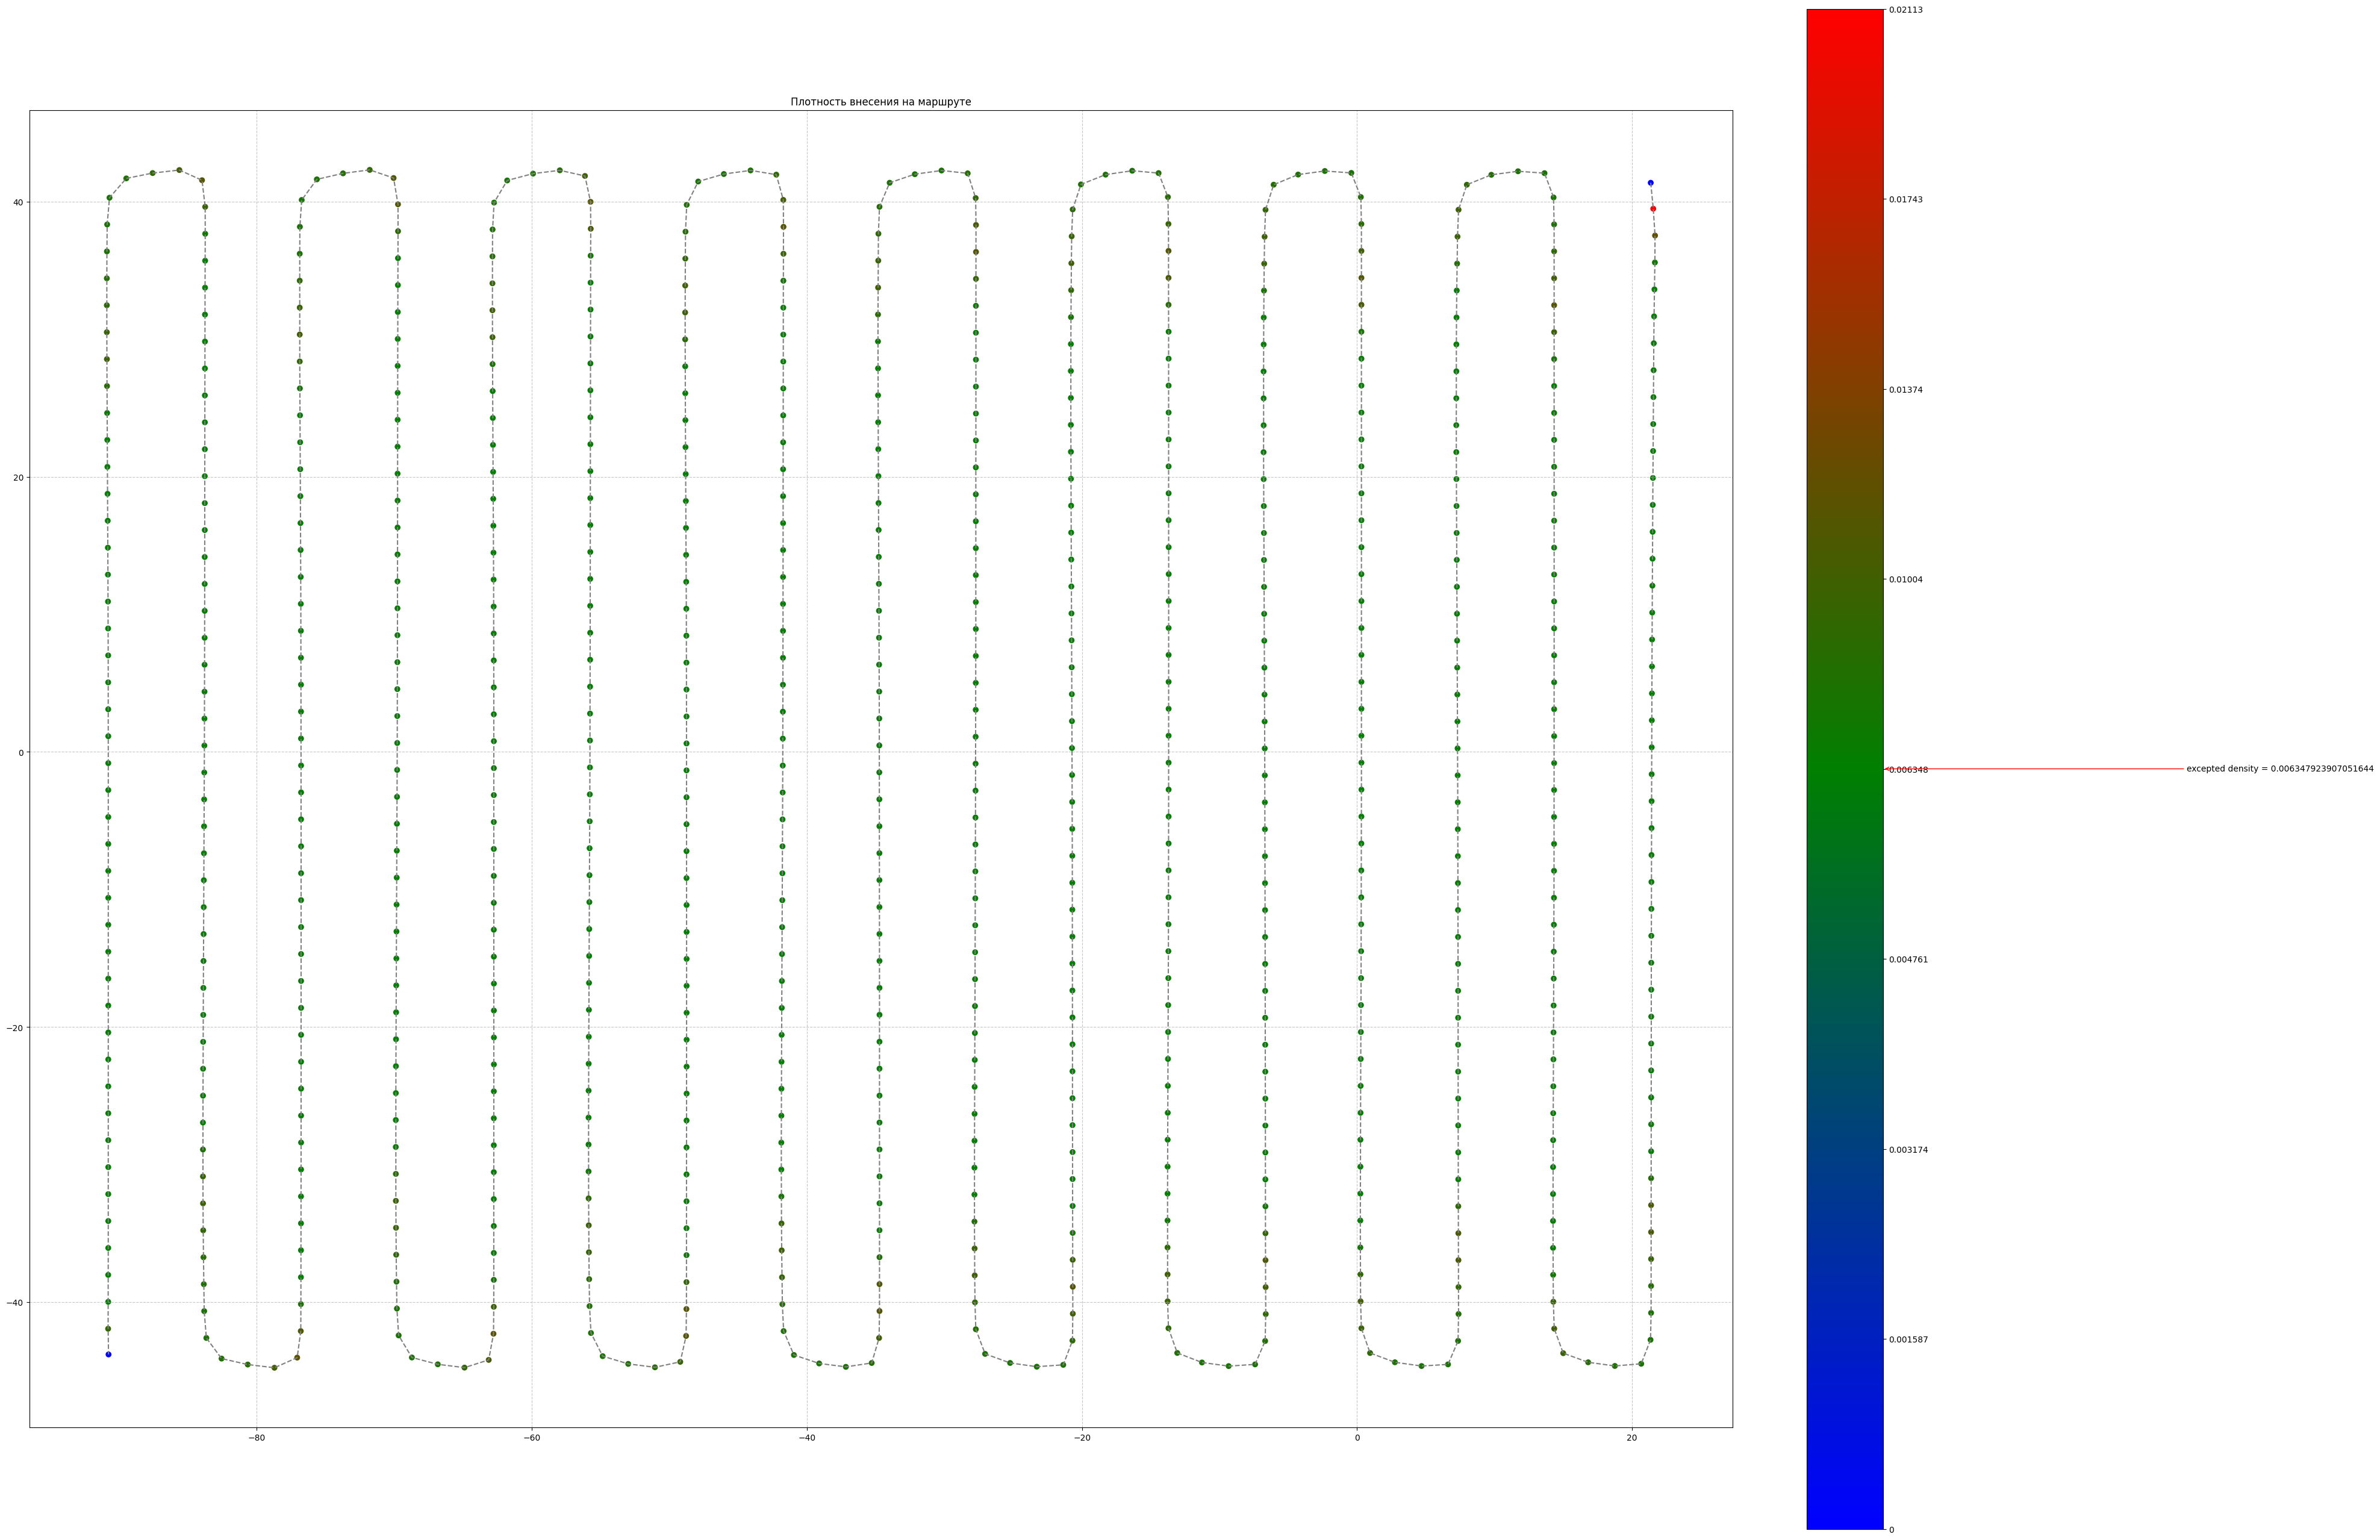

In [23]:
plot_density_profile(list_pts,
                     pump_plan_by_logs.q,
                     speed_list_by_logs,
                     V_total / profile_by_logs.total_distance)